In [1]:
# The goal of this notebook is to create an environment to 
# trace the sourece of performance problem to detect change
# points and other data science problem

# base code: the original code was downloaded from SVN rev 53

# Organization:
# * Repeat existing method from rev53
# * Implement and test on Bayesian change point detection method
# * etc.

In [2]:
# load a few necessary packages

%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## Re-run change point detection using off-line method

In [3]:
# Import data
# This part of code was from [rev 53]

import numpy as np
from os import path
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from scipy.special import gammaln
from scipy.misc import comb
from scipy.misc import logsumexp
from decorator import decorator
from functools import partial

from bayesian_cp_detect.changepoint_detection import cp_detect
from bayesian_cp_detect.viterbi_delta import disaggregation
from bayesian_cp_detect.file_readef import *
from bayesian_cp_detect.outlierdef import *
from bayesian_cp_detect.datadef import *


Example data

In [4]:
# Define parameters

####################################################
#define status space/# of appliances/min# of status#
downsampling_interval=30 #whether downsampling
smooth=0 #whether smooth data

status=np.array([[0,1,2,3,4],
                 [0,1,2,3,4,5], # changeable only two status [0,1]
                 [0,1]])

power=np.array([[0,38,76,114,152],
                [0,130,190,210,285,333], #changeable [0,min,max]
                [0,28]])              


freq_conversion=np.array([0,1,0])

conditions=np.array([1,0,1])
sampling_interval=15 #datapoints per hour
num_change=1 #define max # of changing unit:1 to num_app
####################################################

#4.1 4.11 4.16
#Hstart:Hend--every 6 hours
#0-5, 6-11, 12-17, 18-23
date='4-16'
Hstart=19
Hend=23

In [5]:
# Load raw data

(t,y)=np.array(readfile(date,Hstart,Hend,folder='data/IHG/'))
y_raw = y
t_raw = t

y_raw_4_16_19_23 = y_raw
t_raw_4_16_19_23 = t_raw

In [6]:
# Data process
# including down-sampling and filtering; this step sets up data that
# feeds into cp_detect, the main function to detect change point

if downsampling_interval>sampling_interval:
    interval=downsampling_interval/sampling_interval
    sampling_interval=downsampling_interval    
    y=np.array([y[i] for i in range(0,len(y),int(interval))])
    t=np.array([t[i] for i in range(0,len(y))])

y_downsample = y
    
picname=path.join('results', 'disaggr_2016-'+date+' '+str(Hstart)+'h to '+str(Hend)+'h')
# re-assign new parameter names follow convention inside function disaggregation
[filename,t,y,status,power,freq_conversion,conditions,smooth,sampling_interval,num_change] = [
    picname,t,y,status,power,freq_conversion,conditions,smooth,sampling_interval,num_change]

N=len(y)
y=preprocess(y)
y_preprocess = y

y_filtered = y # in the current version, it does not seems to do any smoothing

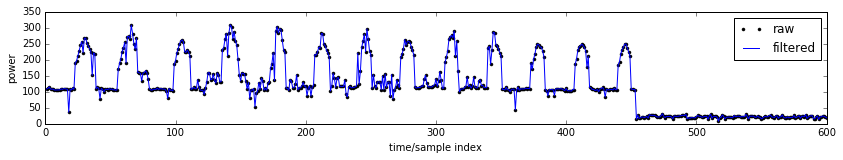

In [7]:
plt.figure(figsize=[14, 2])
plt.plot(t, y, 'k.', label='raw')
plt.plot(t, y_filtered, '-', label='filtered')
plt.legend()
plt.xlabel('time/sample index')
plt.ylabel('power')

### change point detection

In [8]:
from bayesian_cp_detect.changepoint_detection import *

In [9]:
%%time

# test the algorithm time, note that the time is clearly 
# machine-dependent
(idxpcp_start, pcpsum)=cp_detect(y_filtered[::-1])

CPU times: user 35.4 s, sys: 2.28 s, total: 37.7 s
Wall time: 41.9 s


In [10]:
%%time

# test the algorithm time with truncation
(idxpcp_start_2, pcpsum_2)=cp_detect(y_filtered[::-1], truncate=-10)

CPU times: user 16.2 s, sys: 2.01 s, total: 18.2 s
Wall time: 18.7 s


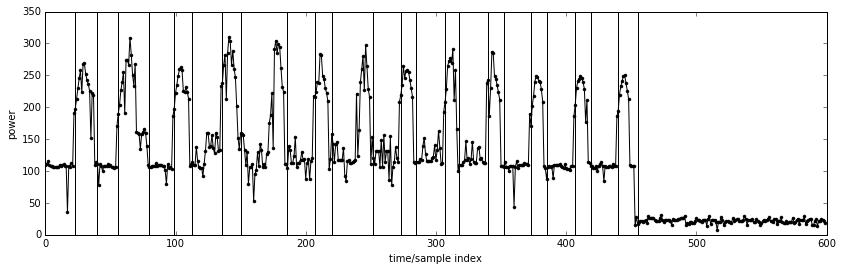

In [11]:
# Plot the disaggregation result

plt.figure(figsize=[14,4])
plt.plot(y_filtered, 'ko-', markersize=3)

for cp in idxpcp_start:
    plt.plot([len(y_filtered)-cp,len(y_filtered)-cp], [0, 350], 'k-')

plt.xlabel('time/sample index')
plt.ylabel('power')

Conclusion:

* cp_detect() detect change point reasonably well, potentially does not identify short changes (see ~80 in the plot above)
* add truncating helps to reduce the running time, but only in the first phase.

## Online bayesian-style method for changepoint detection

In [12]:
# # a function to inspect the current version of code
# import inspect
# def print_func(func):
#     for line in inspect.getsourcelines(func)[0]:
#         print line.rstrip()
        
# from bayesian_cp_detect.cp_detect import *

# # print a copy of current version of functions
# print_func(bayesian_change_point)
# print_func(get_change_point)
# print_func(get_posterior)

In [13]:
# def del_func(func_name):
#     try:
#         del globals()[func_name]
#         print 'deleted ' + func_name
#     except:
#         print 'failed to delete ' + func_name
        
# # make sure that the following functions are not defined
# del_func('bayesian_change_point')
# del_func('get_change_point')
# del_func('plot_change_point')
# del_func('get_dist_to_last_cp')
# del_func('get_posterior')

bayesian_change_point() takes a list of power as inputs, and return three lists of same length as input, each element in the list are a list of varying length. These lists are, conditioned on the distance to the last change points, the posterial mean and std of average intensity and conditional probability.

The code below tests the performance of the code and impacts of parameters

In [14]:
from bayesian_cp_detect.cp_detect import *

In [15]:
%%time

print 'size of input: %d' % len(preprocess(y_raw))
[mu_list_list, sigma_list_list, prob_r_list_list] = bayesian_change_point(preprocess(y_raw))

size of input: 1200
CPU times: user 1.19 s, sys: 24 ms, total: 1.21 s
Wall time: 1.29 s


In [16]:
%%time

print 'size of input: %d' % len(preprocess(y_raw))
[mu_list_list, sigma_list_list, prob_r_list_list_2] = bayesian_change_point(preprocess(y_raw), TOL = None)

size of input: 1200
CPU times: user 7.87 s, sys: 118 ms, total: 7.99 s
Wall time: 8.65 s


In [17]:
%%time

print 'size of input: %d' % len(y_preprocess)
[mu_list_list, sigma_list_list, prob_r_list_list_3] = bayesian_change_point(y_preprocess)

size of input: 600
CPU times: user 365 ms, sys: 7.42 ms, total: 372 ms
Wall time: 405 ms


In [18]:
%%time

print 'size of input: %d' % len(preprocess(y_raw))
[mu_list_list, sigma_list_list, prob_r_list_list_4] = bayesian_change_point(preprocess(y_raw))

size of input: 1200
CPU times: user 1.02 s, sys: 12.1 ms, total: 1.03 s
Wall time: 1.05 s


(-30, 0)

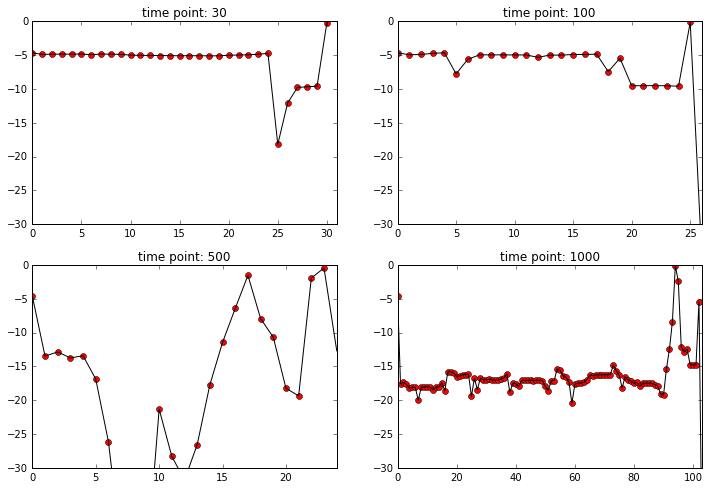

In [19]:
# check the conditional probability difference between with and without truncation

fig, ax = plt.subplots(2,2,figsize=[12,8])

ax[0][0].plot(prob_r_list_list_4[30], 'ro', label='truncated')
ax[0][0].plot(prob_r_list_list_2[30], 'k-', label='no truncation')
ax[0][0].set_title('time point: 30')
ax[0][0].set_xlim([0, len(prob_r_list_list_4[30])])
ax[0][0].set_ylim([-30, 0])

ax[0][1].plot(prob_r_list_list_4[100], 'ro', label='truncated')
ax[0][1].plot(prob_r_list_list_2[100], 'k-', label='no truncation')
ax[0][1].set_title('time point: 100')
ax[0][1].set_xlim([0, len(prob_r_list_list_4[100])])
ax[0][1].set_ylim([-30, 0])

ax[1][0].plot(prob_r_list_list_4[500], 'ro', label='truncated')
ax[1][0].plot(prob_r_list_list_2[500], 'k-', label='no truncation')
ax[1][0].set_title('time point: 500')
ax[1][0].set_xlim([0, len(prob_r_list_list_4[500])])
ax[1][0].set_ylim([-30, 0])

ax[1][1].plot(prob_r_list_list_4[1000], 'ro', label='truncated')
ax[1][1].plot(prob_r_list_list_2[1000], 'k-', label='no truncation')
ax[1][1].set_title('time point: 1000')
ax[1][1].set_xlim([0, len(prob_r_list_list_4[1000])])
ax[1][1].set_ylim([-30, 0])

Conclusion
* Without truncation, the algorithm works faster than original method when using down-sampled input (~2s), 
* but when applying to original sample (twice the size), the algorithm is significantly slower (~7s)
* with truncation (using default as .9999), running time is within 1s. The fold difference between 600 points and 1200 points is roughly the same (3-fold)
* by checking four time point across the 1200 time points, the truncated and un-truncated prob does not look different. Hence in the analysis below, **I will use the truncated version**.


## Test methods to convert conditional probability to changepoint

size of input: 1200
CPU times: user 1.14 s, sys: 11.4 ms, total: 1.15 s
Wall time: 1.17 s


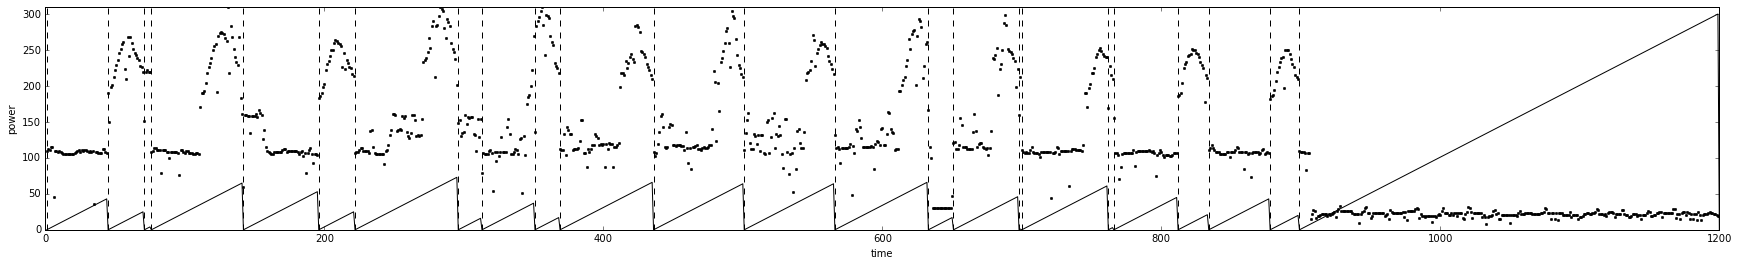

In [20]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input)
changepoint, changepoint_p = get_change_point(prob_r_list_list, min_length_prior=2)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 1200
CPU times: user 1.18 s, sys: 11.6 ms, total: 1.19 s
Wall time: 1.2 s


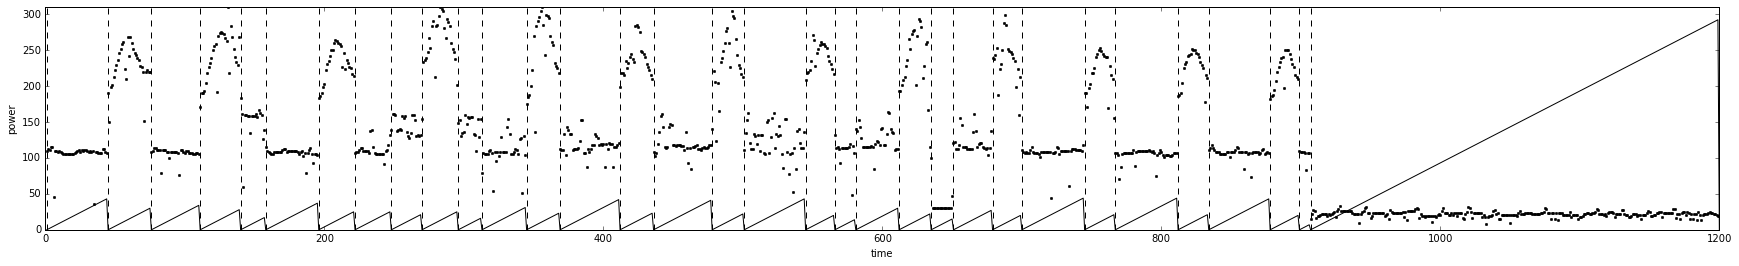

In [21]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 1200
CPU times: user 1.16 s, sys: 8.69 ms, total: 1.17 s
Wall time: 1.2 s


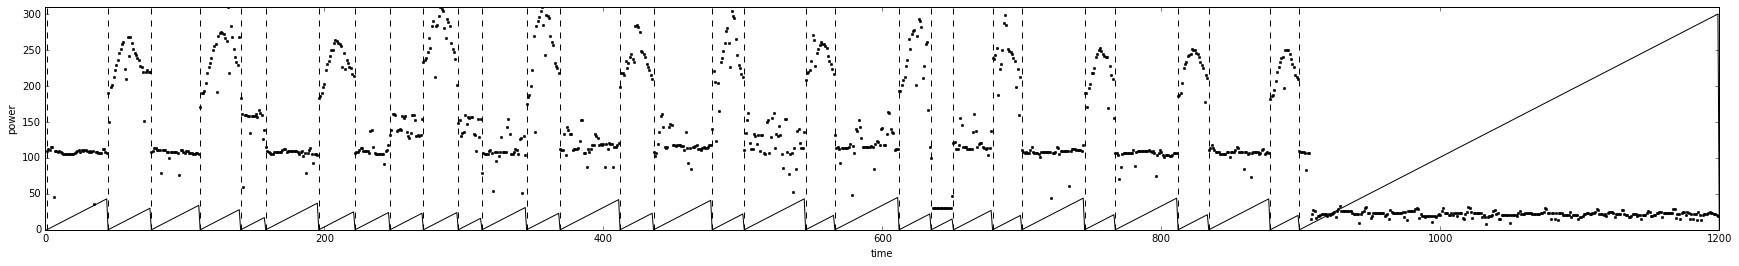

In [22]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input)
changepoint, changepoint_p = get_change_point(prob_r_list_list, min_length_prior=10)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)


The three plots above show the effects of changing min_length_prior to 2, 5, 10. When set as 2, the current algorithm picks up very short changes, which belongs to the tails of a period of signals. When set as 10, the results seem to be quite robust except that the second to the last change was not picked. So **as long as min_length_prior is not below 5, the algorithm works well for this set of data**.

### test effects of sigma_measurement

size of input: 1200
CPU times: user 1.32 s, sys: 21.4 ms, total: 1.35 s
Wall time: 1.41 s


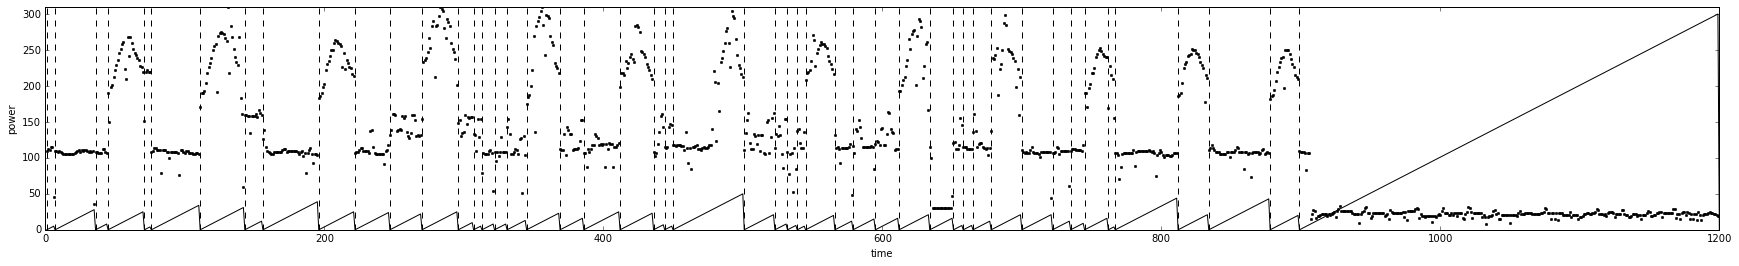

In [23]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, sigma_measurement=10)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 1200
CPU times: user 1.18 s, sys: 7.7 ms, total: 1.19 s
Wall time: 1.21 s


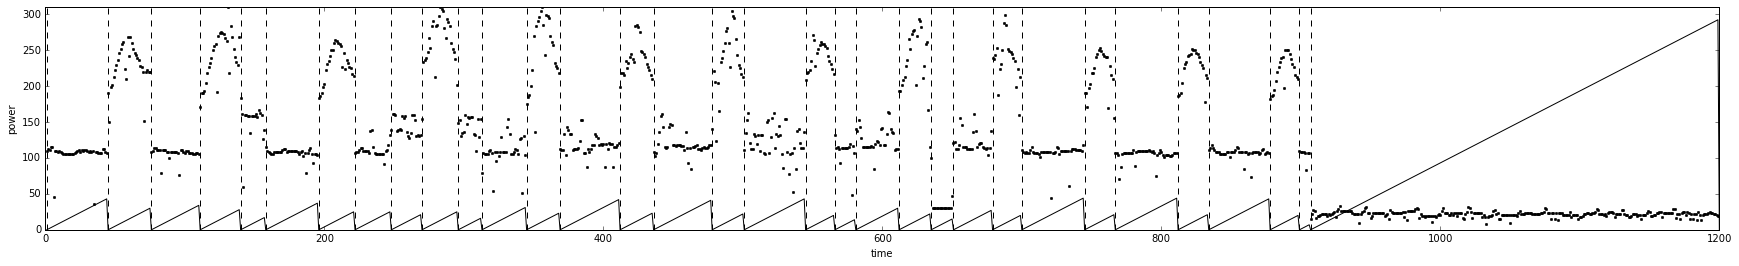

In [24]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, sigma_measurement=20)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 1200
CPU times: user 1.2 s, sys: 22.1 ms, total: 1.22 s
Wall time: 1.22 s


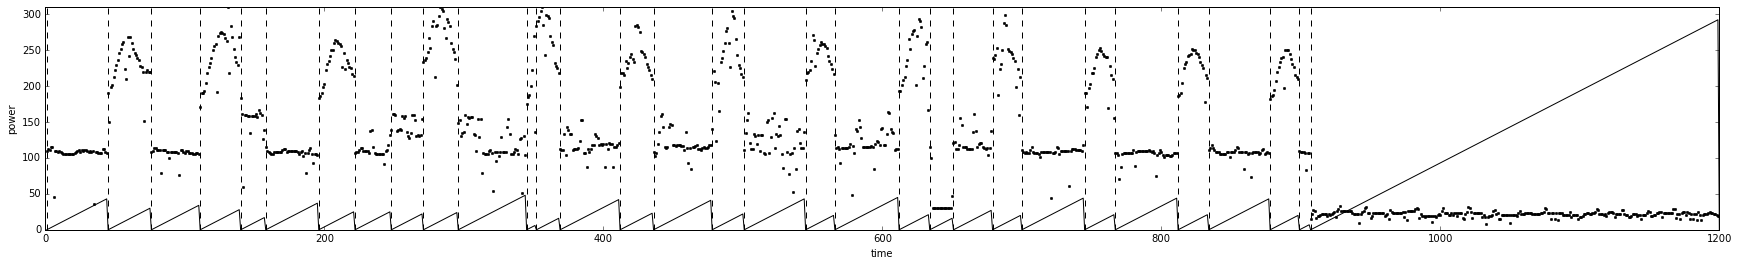

In [25]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, sigma_measurement=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

As expected as assumed measurement noise increase, changepoint detection become less stringent (less cp detected).

### test the effect of prior length


size of input: 1200
CPU times: user 1.18 s, sys: 14.3 ms, total: 1.19 s
Wall time: 1.22 s


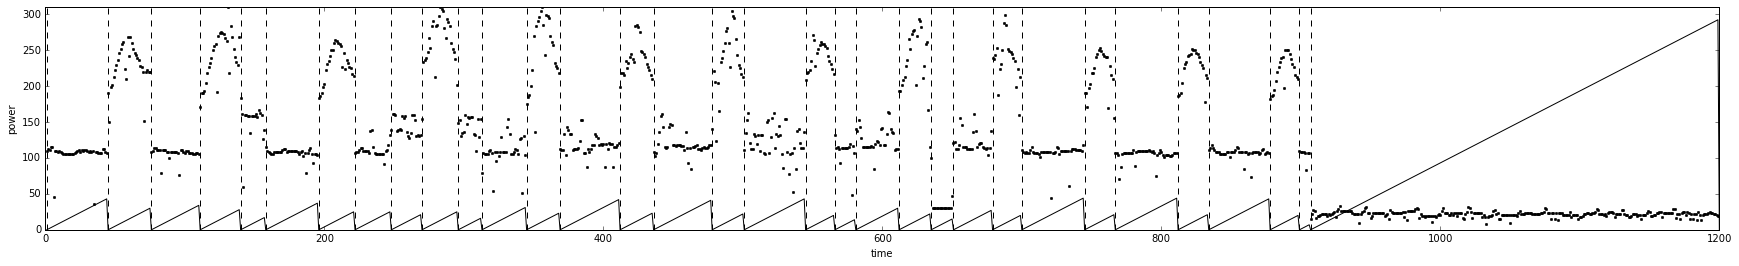

In [26]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 1200
CPU times: user 1.15 s, sys: 9.59 ms, total: 1.16 s
Wall time: 1.2 s


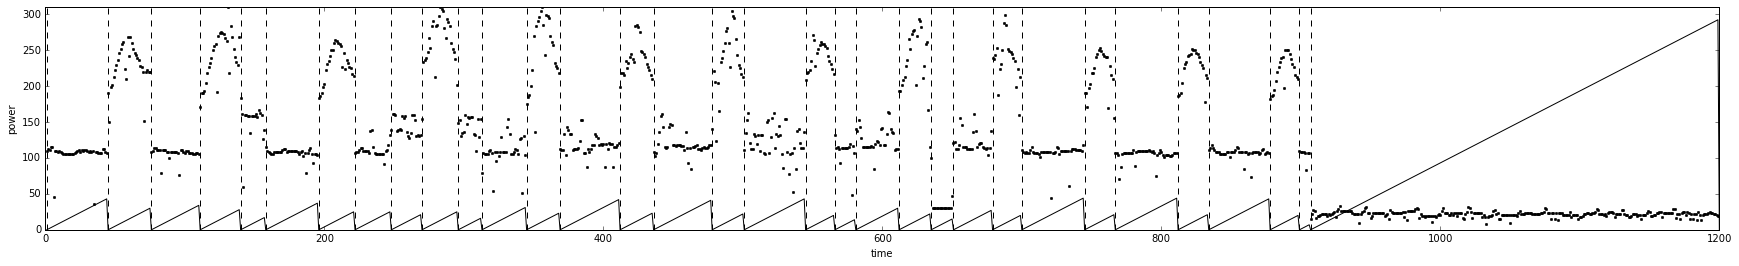

In [27]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, min_length_prior=1)
changepoint, changepoint_p = get_change_point(prob_r_list_list, min_length_prior=5)
plot_change_point(t_raw, preprocess(y_raw), changepoint)
print 'size of input: %d' % len(data_input)

## Apply bayesian changepoint detection to more samples to find limitation

run "python bayesian_cp.py";

There are three types of errors in the cp detection method - 
* for low values, the method is not sensitive enough to pick out small but stable fluctuations (example, 4-4-7-18.jpg);
* for low values, a lot of detected cp do not make any sense (example 4-4-7-18.jpg);
* for large values, a small number of sudden change in power result in change point detection (4-3-7-18.jpg).

In this section, I will try to solve these problems.

In [28]:
# repeat 4-4-7-18
date='4-3'
Hstart=7
Hend=18

# Load raw data

(t,y)=np.array(readfile(date,Hstart,Hend,folder='data/IHG/'))
y_raw = y
t_raw = t


y_raw_4_3_7_18 = y_raw
t_raw_4_3_7_18 = t_raw

In [29]:
def rel_change(y):
    return np.min([np.abs(y[1] - y[0]), np.abs(y[1] - y[2])]) / float(y[1])

def rel_change_filter(t, data_input, thre=.2):
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre/(1-thre))
    ]
    id_filter2 = np.setdiff1d(range(len(data_input)), id_filter)
    t_2 = [t[i] for i in id_filter2]
    data_input_2 = [data_input[i] for i in id_filter2]
    return t_2, data_input_2

In [30]:
%%time
data_input =preprocess(y_raw)
t_2, y_2 = rel_change_filter(t_raw, data_input,thre=.2)

mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(y_2
                                                                        , sigma_measurement=20)
changepoint, changepoint_p = get_change_point(prob_r_list_list)

CPU times: user 5.71 s, sys: 50 ms, total: 5.76 s
Wall time: 5.95 s


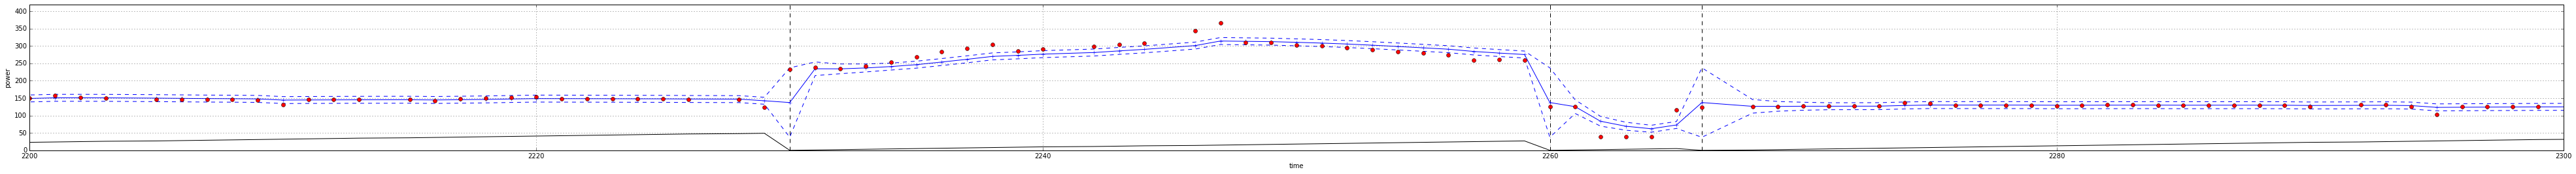

In [31]:
fig = plot_change_point(t_2, y_2, changepoint)
a = get_posterior(y_2, changepoint)
plt.plot(t_2, a[0], 'b+-')
plt.plot(t_2, np.array(a[0])+np.array(a[1]), 'b--')
plt.plot(t_2, np.array(a[0])-np.array(a[1]), 'b--' )
plt.plot(t_2, y_2, 'ro')
plt.xlim([2200, 2300])
plt.grid()
# fig.set_size_inches(18.5, 10.5)

In [32]:
%%time
data_input =preprocess(y_raw)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, sigma_measurement=20)
changepoint, changepoint_p = get_change_point(prob_r_list_list)

CPU times: user 5.95 s, sys: 74.9 ms, total: 6.02 s
Wall time: 6.35 s


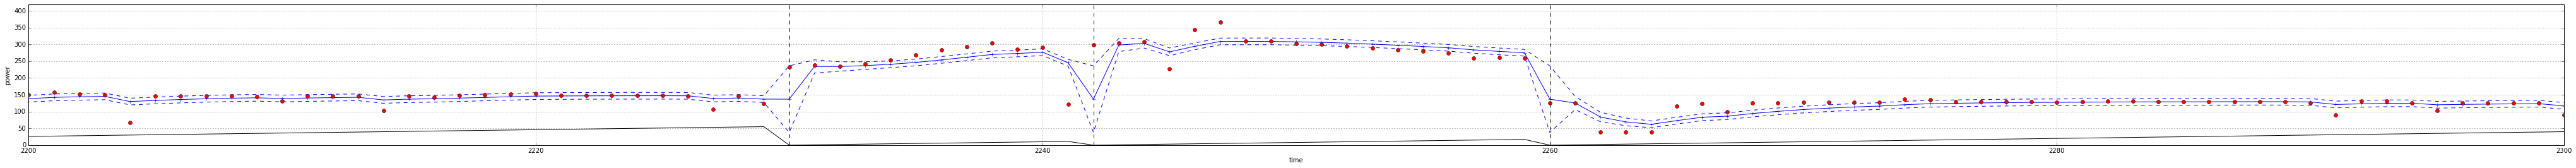

In [33]:
fig = plot_change_point(t_raw, preprocess(y_raw), changepoint)
a = get_posterior(preprocess(y_raw), changepoint)
plt.plot(t_raw, a[0], 'b+-')
plt.plot(t_raw, np.array(a[0])+np.array(a[1]), 'b--')
plt.plot(t_raw, np.array(a[0])-np.array(a[1]), 'b--' )
plt.plot(t_raw, preprocess(y_raw), 'ro')
plt.xlim([2200, 2300])
plt.grid()
# fig.set_size_inches(18.5, 10.5)

## Try to make bayesian_change_point faster

In [34]:
%%time
t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, min_length_prior=5)

CPU times: user 1.07 s, sys: 11.8 ms, total: 1.08 s
Wall time: 1.11 s


remove all storage code in bayesian_change_point(), to see if this helps with speed

In [35]:
# from bayesian_cp_detect.cp_detect import bayesian_change_point_2
# reload(cp_detect)
from bayesian_cp_detect.cp_detect import *

In [36]:
%%time
t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point_2(data_input, min_length_prior=5)

CPU times: user 1.14 s, sys: 19.8 ms, total: 1.16 s
Wall time: 1.31 s


In [37]:
%%time
t = t_raw_4_3_7_18
y = y_raw_4_3_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, min_length_prior=5)

CPU times: user 6.14 s, sys: 63.1 ms, total: 6.2 s
Wall time: 6.56 s


In [38]:
%%time
t = t_raw_4_3_7_18
y = y_raw_4_3_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point_2(data_input, min_length_prior=5)

CPU times: user 5.76 s, sys: 62.6 ms, total: 5.82 s
Wall time: 5.88 s


one idea is to reduce the number of elements in prob_r_list_list

size of input: 1200
CPU times: user 1.13 s, sys: 11.9 ms, total: 1.14 s
Wall time: 1.14 s


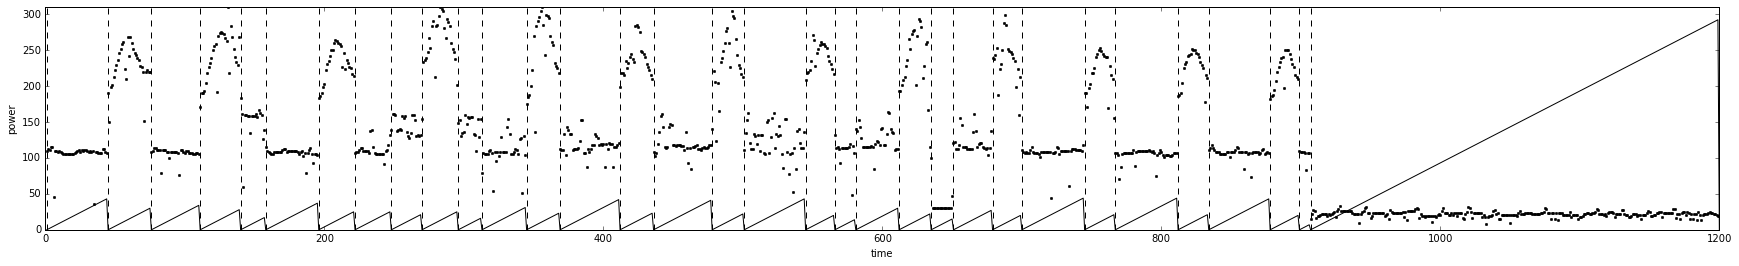

In [39]:
%%time

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

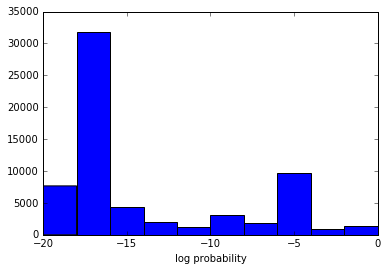

In [40]:
t = [x for t in prob_r_list_list for x in t]
plt.hist(t, range=[-20, 0])
plt.xlabel('log probability')

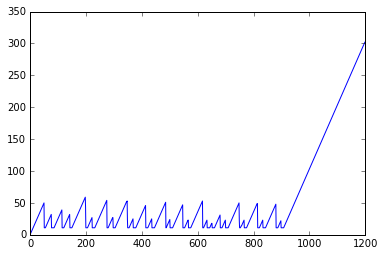

In [41]:
plt.plot([len(t) for t in prob_r_list_list])

In [42]:
from bayesian_cp_detect.cp_detect import *
# bayesian_change_point_3 included, a version that filter small prob

size of input: 1200
CPU times: user 685 ms, sys: 14.4 ms, total: 700 ms
Wall time: 699 ms


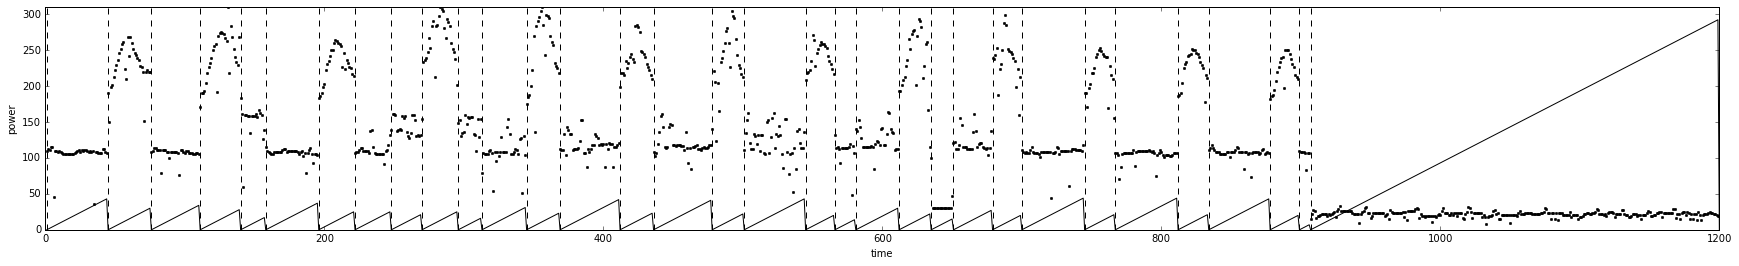

In [43]:
%%time

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_3(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

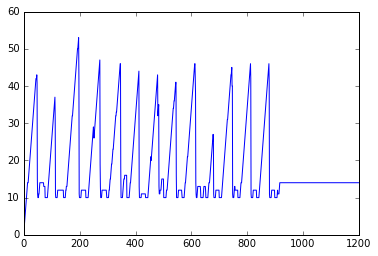

In [44]:
# Plot the number of prob recorded
plt.plot([len(t) for t in prob_r_list_list])

size of input: 2880
CPU times: user 1.51 s, sys: 20.2 ms, total: 1.53 s
Wall time: 1.52 s


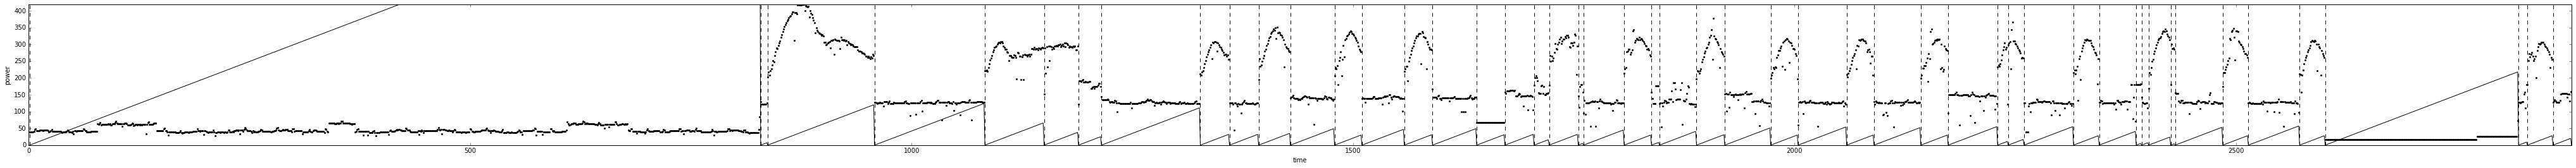

In [45]:
%%time

t = t_raw_4_3_7_18
y = y_raw_4_3_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_3(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

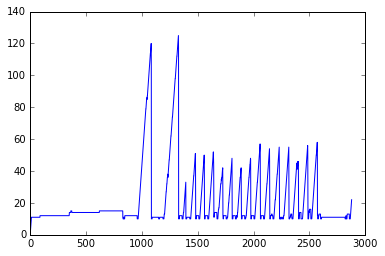

In [46]:
# Plot the number of prob recorded
plt.plot([len(t) for t in prob_r_list_list])

## Small value

In [47]:
# repeat 4-4-7-18
date='4-4'
Hstart=7
Hend=18

# Load raw data

(t,y)=np.array(readfile(date,Hstart,Hend,folder='data/IHG/'))
y_raw_4_4_7_18 = y
t_raw_4_4_7_18 = t

size of input: 2880
CPU times: user 15.7 s, sys: 170 ms, total: 15.9 s
Wall time: 16.2 s


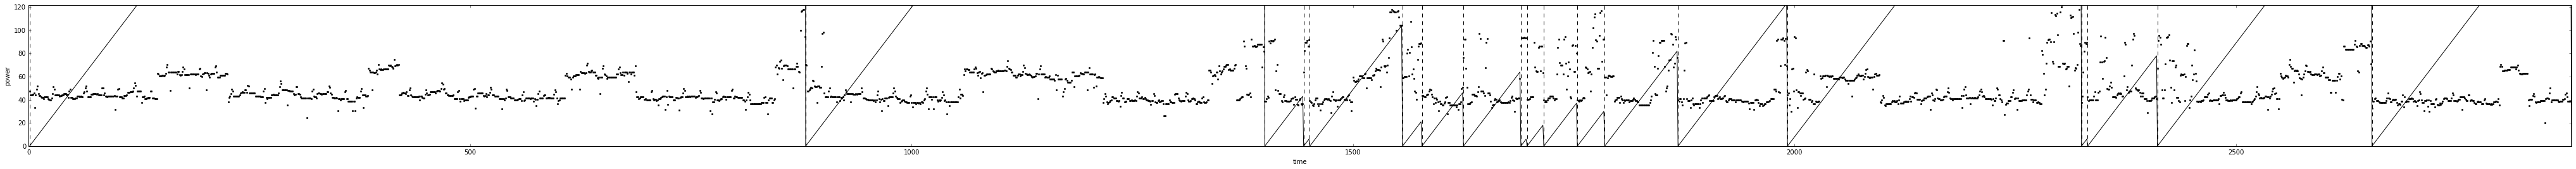

In [48]:
%%time

t = t_raw_4_4_7_18
y = y_raw_4_4_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list = bayesian_change_point(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 2880
CPU times: user 14.3 s, sys: 176 ms, total: 14.5 s
Wall time: 15 s


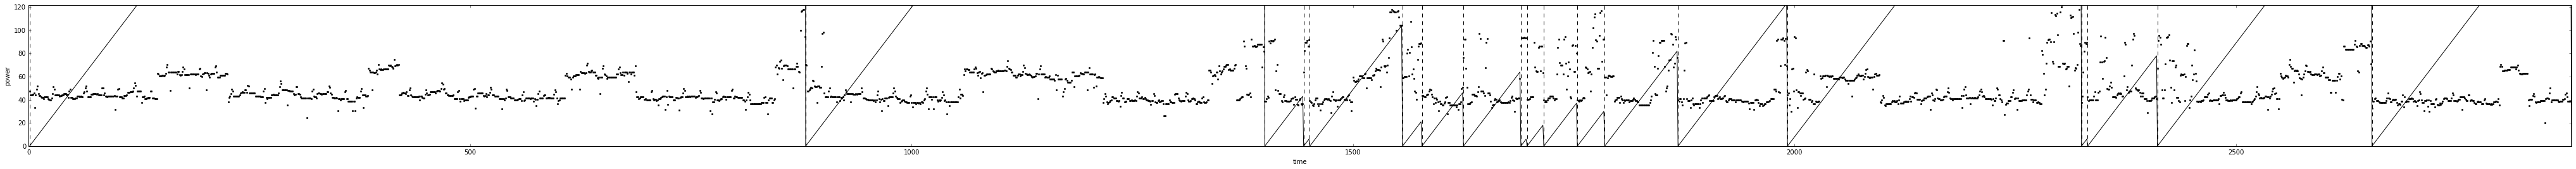

In [49]:
%%time

t = t_raw_4_4_7_18
y = y_raw_4_4_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_3(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

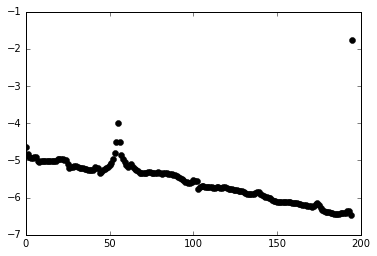

In [50]:
plt.plot(prob_r_list_list[200], 'ko')

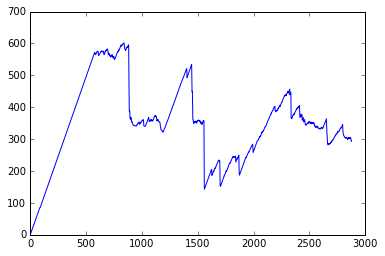

In [51]:
plt.plot([len(t) for t in prob_r_list_list])

size of input: 2880
CPU times: user 4.59 s, sys: 39.5 ms, total: 4.63 s
Wall time: 4.63 s


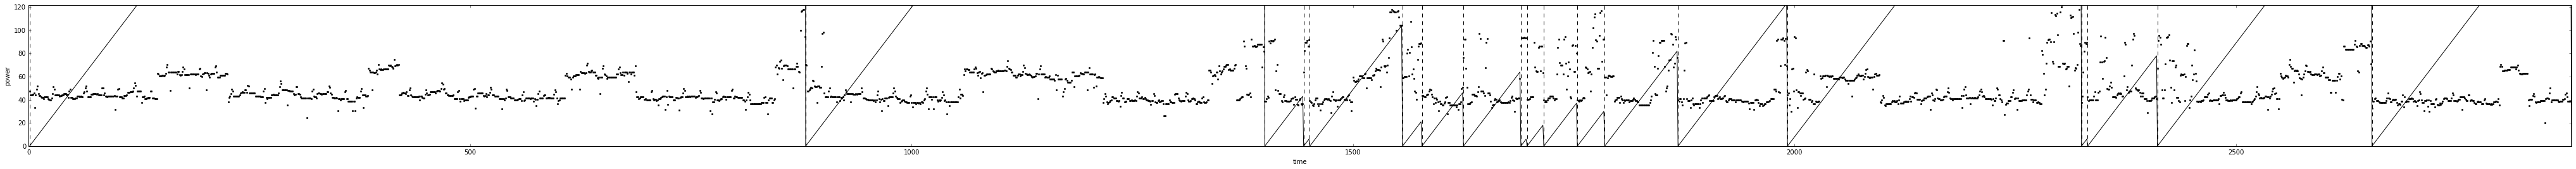

In [52]:
%%time

t = t_raw_4_4_7_18
y = y_raw_4_4_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, min_length_prior=5)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

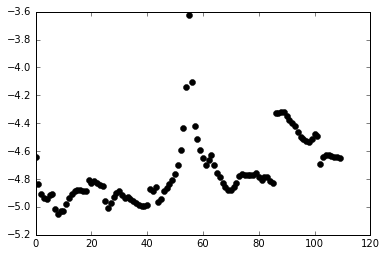

In [53]:
plt.plot(prob_r_list_list[200], 'ko')

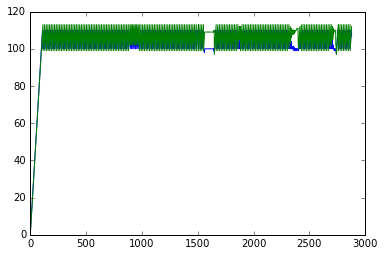

In [54]:
plt.plot([len(t) for t in prob_r_list_list])
plt.plot([max(t) for t in r_list_list])

size of input: 2880
CPU times: user 3 s, sys: 34.9 ms, total: 3.03 s
Wall time: 3.12 s


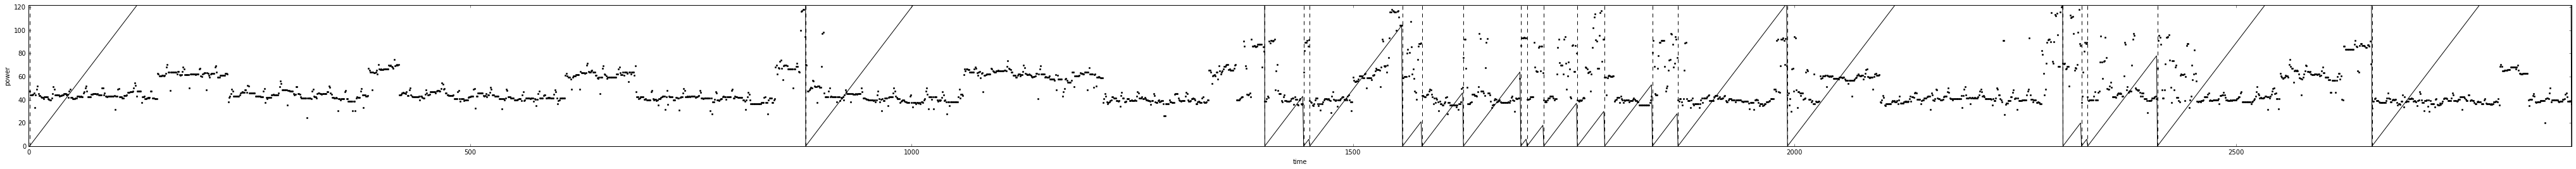

In [55]:
%%time

t = t_raw_4_4_7_18
y = y_raw_4_4_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=50)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 2880
CPU times: user 2.05 s, sys: 26.5 ms, total: 2.08 s
Wall time: 2.17 s


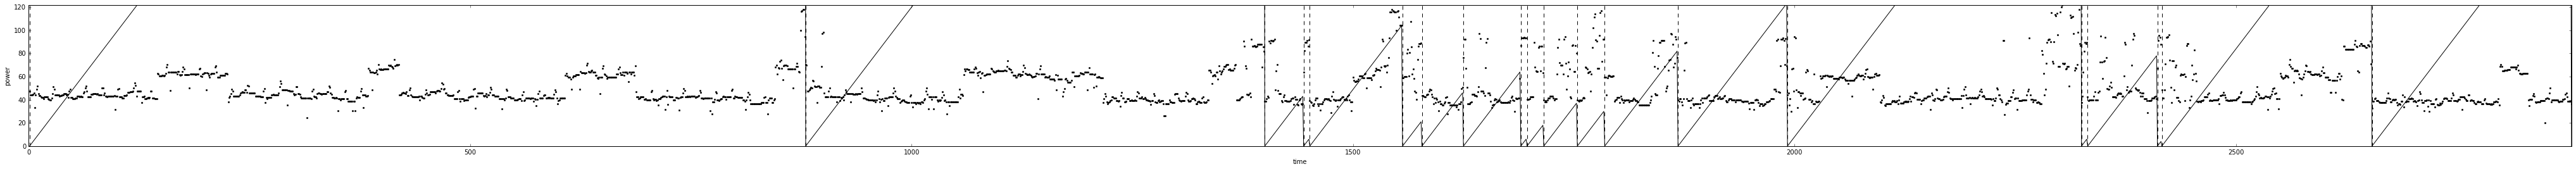

In [56]:
%%time

t = t_raw_4_4_7_18
y = y_raw_4_4_7_18

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

size of input: 1200
CPU times: user 684 ms, sys: 6.74 ms, total: 691 ms
Wall time: 699 ms


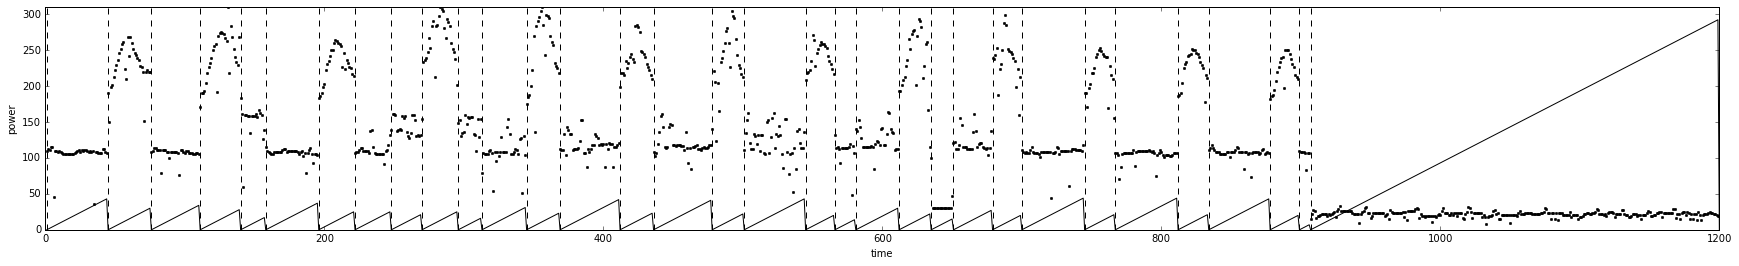

In [57]:
%%time

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

data_input =preprocess(y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

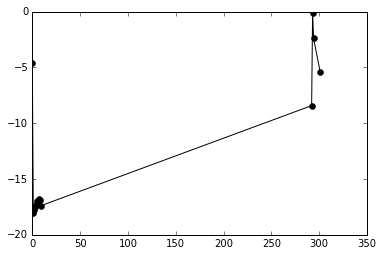

In [58]:
plt.plot(r_list_list[-1], prob_r_list_list[-1], 'ko-')

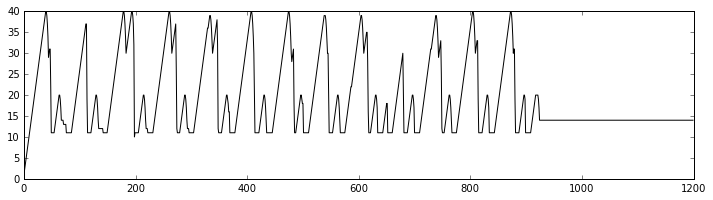

In [59]:
# the number of r recorded per position
plt.figure(figsize=[12, 3])
plt.plot(
    [len(prob_r_list_list[i]) 
     for i in range(len(prob_r_list_list))
    ], 'k-')

size of input: 1137
CPU times: user 606 ms, sys: 8.97 ms, total: 615 ms
Wall time: 610 ms


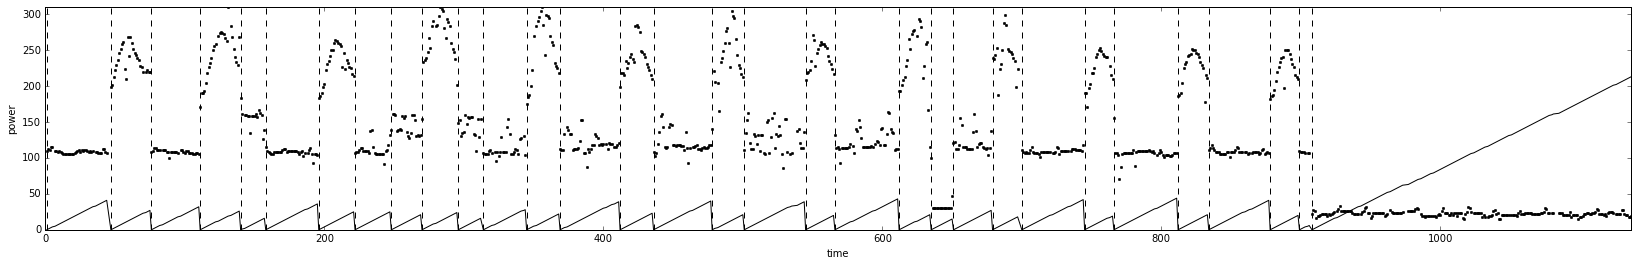

In [60]:
%%time

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

t, y = rel_change_filter(t, y, thre=.2)
data_input = y

mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

## Pool and align many change point

In [61]:
def load_dat(date, Hstart, Hend):
    (t,y) = np.array(readfile(date,Hstart,Hend,folder='data/IHG/'))
    return t, y

def filter_dat(t, y):
    t_2, y_2 = rel_change_filter(t, y, thre=.2)
    return t_2, y_2

def disaggregate(dat):
    mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(dat, r_blur=30)
    changepoint, changepoint_p = get_change_point(prob_r_list_list)
    dat_seg = [dat[cp_1:cp_2] for cp_1, cp_2 in zip(changepoint[:-1], changepoint[1:])]
    return dat_seg, changepoint

In [62]:
t, y = load_dat('4-1', 7, 18)
t, y = filter_dat(t, y)

size of input: 2792
CPU times: user 1.8 s, sys: 16.1 ms, total: 1.82 s
Wall time: 1.81 s


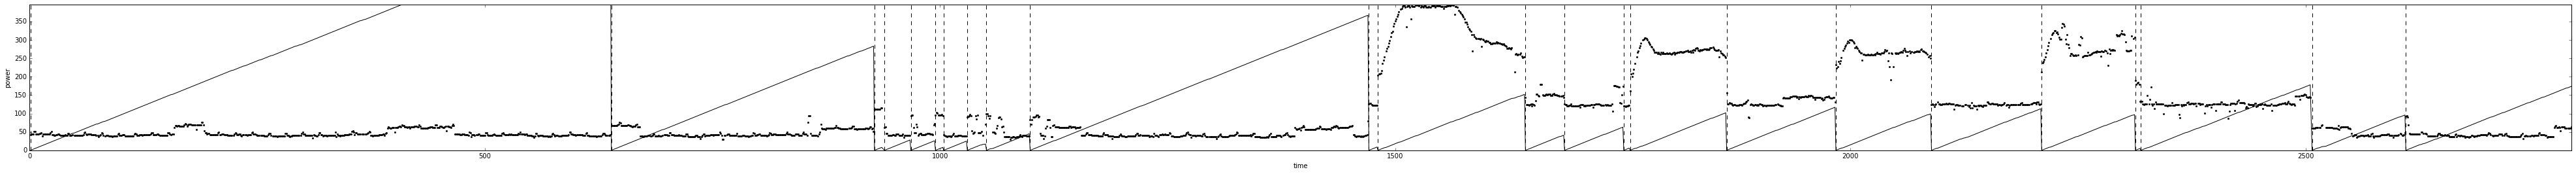

In [63]:
%%time

t_2, y_2 = rel_change_filter(t, y, thre=.2)
data_input = y_2

mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_2, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

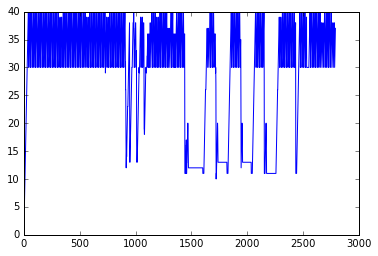

In [64]:
plt.plot([len(t) for t in prob_r_list_list])

In [65]:
%%time
[dat_seg, changepoint] = disaggregate(y)

CPU times: user 1.65 s, sys: 15.2 ms, total: 1.67 s
Wall time: 1.66 s


In [66]:
def normalize_by_last_point(dat_seg):
    last_p = 0
    new_dat_seg = []
    for seg in dat_seg:
        new_dat_seg.append([x - last_p for x in seg])
        last_p = seg[-1]
    new_dat_seg.pop(0)
    return new_dat_seg

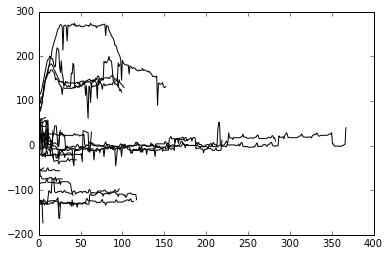

In [67]:
dat_seg_new = normalize_by_last_point(dat_seg)
for seg in dat_seg_new:
    plt.plot(seg, 'k-')

In [68]:
def align_cp_plot(date, Hstart, Hend):
    print date, Hstart, Hend
    t, y = load_dat(date, Hstart, Hend)
    t, y = filter_dat(t, y)
    [dat_seg, changepoint] = disaggregate(y)
    dat_seg_new = normalize_by_last_point(dat_seg)
    for seg in dat_seg_new:
        plt.plot(seg, 'k-')

4-16 19 23


(0, 100)

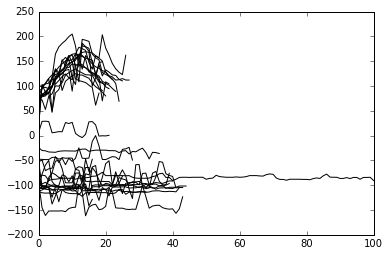

In [69]:
align_cp_plot('4-16', 19, 23)
plt.xlim([0, 100])

4-1 7 18


(0, 100)

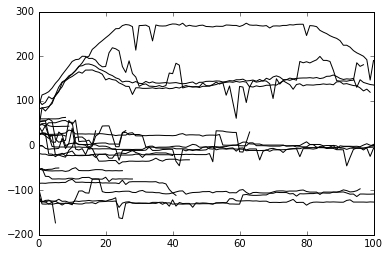

In [70]:
align_cp_plot('4-1', 7, 18)
plt.xlim([0, 100])

4-16 7 18


(0, 100)

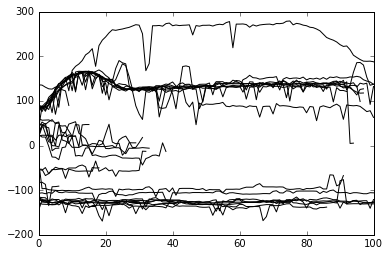

In [71]:
align_cp_plot('4-16', 7, 18)
plt.xlim([0, 100])

4-8 7 18


(0, 100)

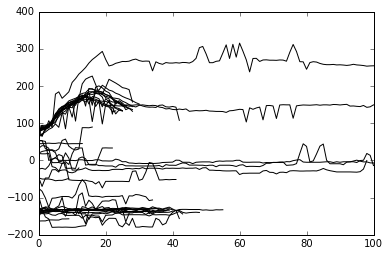

In [72]:
align_cp_plot('4-8', 7, 18)
plt.xlim([0, 100])

In [73]:
date_start = datetime.date(2016,4,1)
date_end = datetime.date(2016,5,1)
date_current = date_start

all_seg = []
all_seg_2 = []

while date_current < date_end:
    date = str(date_current.month) + '-' + str(date_current.day)

    Hstart=7
    Hend=18
    
    print date, Hstart, Hend
    
    t, y = load_dat(date, Hstart, Hend)
    t, y = filter_dat(t, y)
    [dat_seg, changepoint] = disaggregate(y)
    dat_seg_new = normalize_by_last_point(dat_seg)
    all_seg.append(dat_seg_new)
    all_seg_2.extend(dat_seg_new)
    
    date_current += datetime.timedelta(1)

all_seg_april_last = all_seg
all_seg_2_april_last = all_seg_2  

4-1 7 18
4-2 7 18
4-3 7 18
4-4 7 18
4-5 7 18
4-6 7 18
4-7 7 18
4-8 7 18
4-9 7 18
4-10 7 18
4-11 7 18
4-12 7 18
4-13 7 18
4-14 7 18
4-15 7 18
4-16 7 18
4-17 7 18
4-18 7 18
4-19 7 18
4-20 7 18
4-21 7 18
4-22 7 18
4-23 7 18
4-24 7 18
4-25 7 18
4-26 7 18
4-27 7 18
4-28 7 18
4-29 7 18
4-30 7 18


(0, 100)

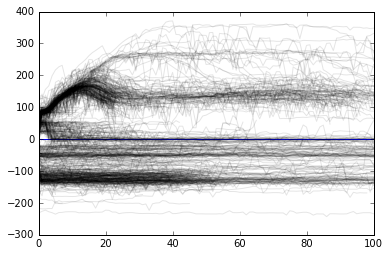

In [74]:
plt.plot([0,100],[0,0], 'b-')
for seg in all_seg_2:
    plt.plot(seg, 'k-', linewidth=1, alpha=.1)
plt.xlim([0, 100])


In [75]:
def normalize_by_last_n_point(dat_seg, n=3):
    last_p = 0
    new_dat_seg = []
    for seg in dat_seg:
        new_dat_seg.append([x - last_p for x in seg])
        last_p = np.mean(seg[-n:])
    new_dat_seg.pop(0)
    return new_dat_seg

def align_cp_plot_2(date, Hstart, Hend):
    print date, Hstart, Hend
    t, y = load_dat(date, Hstart, Hend)
    t, y = filter_dat(t, y)
    [dat_seg, changepoint] = disaggregate(y)
    dat_seg_new = normalize_by_last_n_point(dat_seg)
    for seg in dat_seg_new:
        plt.plot(seg, 'k-')

In [76]:
date_start = datetime.date(2016,4,1)
date_end = datetime.date(2016,5,1)
date_current = date_start

all_seg = []
all_seg_2 = []

while date_current < date_end:
    date = str(date_current.month) + '-' + str(date_current.day)

    Hstart=7
    Hend=18
    
    print date, Hstart, Hend
    
    t, y = load_dat(date, Hstart, Hend)
    t, y = filter_dat(t, y)
    [dat_seg, changepoint] = disaggregate(y)
    dat_seg_new = normalize_by_last_point(dat_seg)
    all_seg.append(dat_seg_new)
    all_seg_2.extend(dat_seg_new)
    
    date_current += datetime.timedelta(1)

all_seg_april = all_seg
all_seg_2_april = all_seg_2

4-1 7 18
4-2 7 18
4-3 7 18
4-4 7 18
4-5 7 18
4-6 7 18
4-7 7 18
4-8 7 18
4-9 7 18
4-10 7 18
4-11 7 18
4-12 7 18
4-13 7 18
4-14 7 18
4-15 7 18
4-16 7 18
4-17 7 18
4-18 7 18
4-19 7 18
4-20 7 18
4-21 7 18
4-22 7 18
4-23 7 18
4-24 7 18
4-25 7 18
4-26 7 18
4-27 7 18
4-28 7 18
4-29 7 18
4-30 7 18


(0, 100)

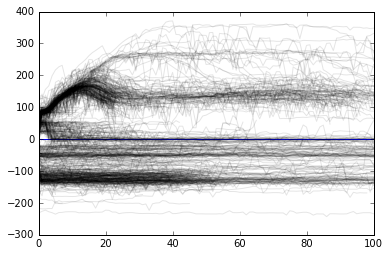

In [77]:
plt.plot([0,100],[0,0], 'b-')
for seg in all_seg_2:
    plt.plot(seg, 'k-', linewidth=1, alpha=.1)
plt.xlim([0, 100])

## download more data

In [78]:
from loadTools import *

In [79]:
user = 'HIKQ'
pswd = 'HIKQ'
server = 'app.equotaenergy.com'
ID = '143'
start_dt = datetime.datetime(2016, 7, 1)
end_dt = datetime.datetime(2016, 7, 1, 0, 30)
# points = load_data().download_series_from_DB(user, pswd, server, ID, limit=1)
points_sr = load_data().get_series_as_pd(user, pswd, server, ID, start_dt,
                                         end_dt)
points_sr.to_csv('test.csv')

In [80]:
date_current, end_dt

(datetime.date(2016, 5, 1), datetime.datetime(2016, 7, 1, 0, 30))

In [81]:
# run downloader.py
# python downloader.py > downloader.py.log

In [82]:
def read_dat(date, h_start, h_end, folder_path):
    dat = []
    for h in range(h_start, h_end):
        try:
            file_name = '%d-%d-%d.csv' % (date.month, date.day, h)
            file_path = path.join(folder_path, file_name)
            tmp = pd.read_csv( file_path )
            dat.extend( [t[1]/3 for t in tmp.values] )
        except:
            print '%s failed' % file_name
    return dat

28


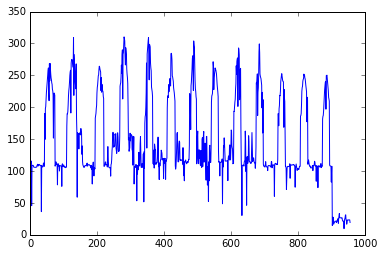

In [83]:
dat = read_dat(datetime.datetime(2016, 4, 16), 19, 23, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time
plt.plot(t,y)

t, y = filter_dat(t, y)
[dat_seg, changepoint] = disaggregate(y)
dat_seg_new = normalize_by_last_point(dat_seg)
print len(dat_seg_new)

7


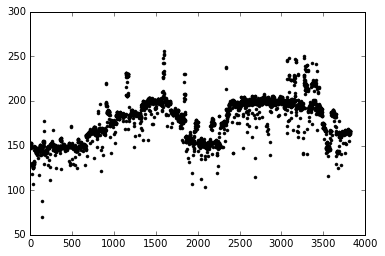

In [84]:
dat = read_dat(datetime.datetime(2016, 7, 1), 7, 23, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time
t, y = filter_dat(t, y)
plt.plot(t,y, 'k.')

[dat_seg, changepoint] = disaggregate(y)
dat_seg_new = normalize_by_last_point(dat_seg)
print len(dat_seg_new)

size of input: 5261


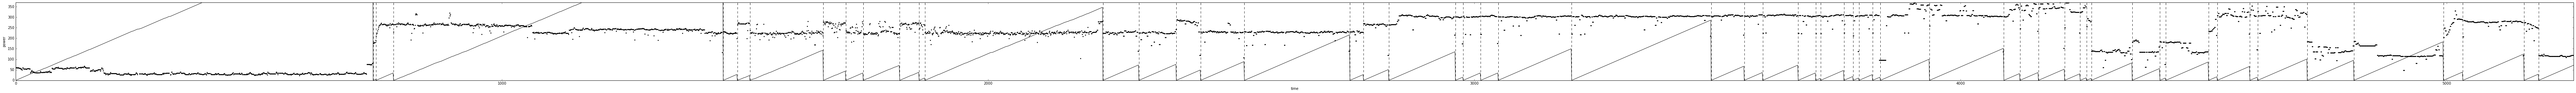

In [85]:
dat = read_dat(datetime.datetime(2016, 5, 28), 7, 23, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t_2, y_2 = rel_change_filter(t, y, thre=.2)
data_input = y_2

mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t_2, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)

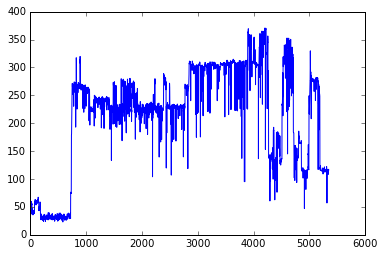

In [86]:
plt.plot(t_2, y_2)

In [87]:
date_start = datetime.date(2016,4,1)
date_end = datetime.date(2016,8,1)
date_current = date_start

all_seg = []
all_seg_2 = []
all_seg_time = []

while date_current < date_end:
    date = str(date_current.month) + '-' + str(date_current.day)

    Hstart=7
    Hend=18
    
    print date, Hstart, Hend
    
    dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
    y = dat
    t = range(len(y)) # fake time
    t, y = filter_dat(t, y)
    
#     t, y = load_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
#     t, y = filter_dat(t, y)
    try:
        [dat_seg, changepoint] = disaggregate(y)
        dat_seg_new = normalize_by_last_point(dat_seg)
    except:
        dat_seg_new = []
    all_seg.append(dat_seg_new)
    all_seg_time.append((date_current, Hstart, Hend))
    all_seg_2.extend(dat_seg_new)
    
    date_current += datetime.timedelta(1)

all_seg_4_month = all_seg
all_seg_2_4_month = all_seg_2
all_seg_time_4_month = all_seg_time

4-1 7 18
4-2 7 18
4-3 7 18
4-4 7 18
4-5 7 18
4-6 7 18
4-7 7 18
4-8 7 18
4-9 7 18
4-10 7 18
4-11 7 18
4-12 7 18
4-13 7 18
4-14 7 18
4-15 7 18
4-16 7 18
4-17 7 18
4-18 7 18
4-19 7 18
4-20 7 18
4-21 7 18
4-22 7 18
4-23 7 18
4-24 7 18
4-25 7 18
4-26 7 18
4-27 7 18
4-28 7 18
4-29 7 18
4-30 7 18
5-1 7 18
5-2 7 18
5-3 7 18
5-4 7 18
5-5 7 18
5-6 7 18
5-6-8.csv failed
5-7 7 18
5-8 7 18
5-8-9.csv failed
5-9 7 18
5-10 7 18
5-11 7 18
5-12 7 18
5-13 7 18
5-14 7 18
5-15 7 18
5-16 7 18
5-17 7 18
5-18 7 18
5-19 7 18
5-20 7 18
5-21 7 18
5-21-7.csv failed
5-21-8.csv failed
5-21-9.csv failed
5-21-10.csv failed
5-21-11.csv failed
5-21-12.csv failed
5-21-13.csv failed
5-21-14.csv failed
5-21-15.csv failed
5-21-16.csv failed
5-21-17.csv failed
5-22 7 18


/Users/bh56/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/bh56/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


5-23 7 18
5-24 7 18
5-25 7 18
5-26 7 18
5-27 7 18
5-28 7 18
5-29 7 18
5-30 7 18
5-31 7 18
6-1 7 18
6-2 7 18
6-3 7 18
6-4 7 18
6-5 7 18
6-6 7 18
6-7 7 18
6-8 7 18
6-9 7 18
6-10 7 18
6-11 7 18
6-12 7 18
6-13 7 18
6-14 7 18
6-15 7 18
6-16 7 18
6-17 7 18
6-18 7 18
6-19 7 18
6-20 7 18
6-21 7 18
6-22 7 18
6-23 7 18
6-24 7 18
6-25 7 18
6-26 7 18
6-27 7 18
6-28 7 18
6-29 7 18
6-30 7 18
7-1 7 18
7-2 7 18
7-3 7 18
7-4 7 18
7-5 7 18
7-6 7 18
7-7 7 18
7-8 7 18
7-9 7 18
7-10 7 18
7-11 7 18
7-12 7 18
7-13 7 18
7-14 7 18
7-15 7 18
7-16 7 18
7-17 7 18
7-18 7 18
7-19 7 18
7-19-7.csv failed
7-20 7 18
7-21 7 18
7-22 7 18
7-22-7.csv failed
7-22-8.csv failed
7-22-9.csv failed
7-22-10.csv failed
7-22-11.csv failed
7-22-12.csv failed
7-22-13.csv failed
7-22-14.csv failed
7-23 7 18
7-24 7 18
7-25 7 18
7-26 7 18
7-26-16.csv failed
7-27 7 18
7-28 7 18
7-29 7 18
7-30 7 18
7-31 7 18


(0, 100)

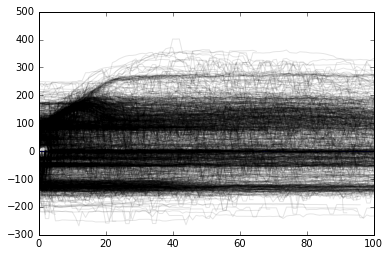

In [88]:
plt.plot([0,100],[0,0], 'b-')
for seg in all_seg_2_4_month:
    plt.plot(seg, 'k-', linewidth=1, alpha=.1)
plt.xlim([0, 100])


(0, 100)

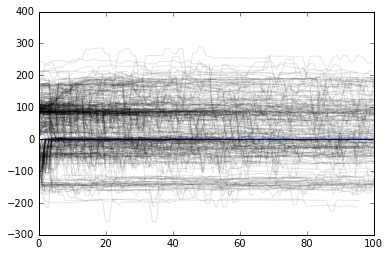

In [89]:
plt.plot([0,100],[0,0], 'b-')

for seg in [x for t in all_seg_4_month[60:90] for x in t]:
    plt.plot(seg, 'k-', linewidth=1, alpha=.1)
plt.xlim([0, 100])


In [90]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [91]:
# example
plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

In [92]:
X = [t[:50] for t in all_seg_2_april if len(t)>50]

In [93]:
n_clusters=6
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

In [94]:
y_pred[:10]

array([5, 5, 4, 1, 0, 2, 0, 2, 0, 5], dtype=int32)

(0, 100)

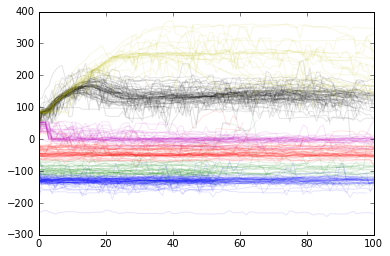

In [95]:
color_list = ['k', 'r', 'b', 'g', 'y', 'm']

for i_cluster in range(n_clusters):
    for seg in [x for i,x in enumerate([t for t in all_seg_2_april if len(t)>50]) if y_pred[i] == i_cluster]:
        plt.plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
plt.xlim([0, 100])


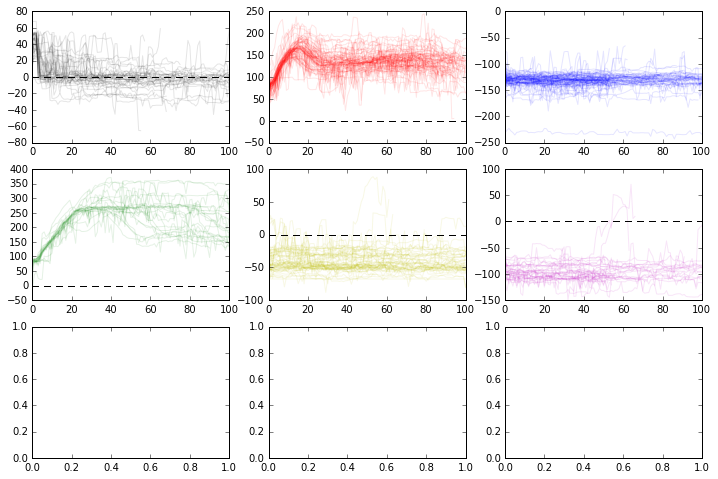

In [96]:
X = [t[:50] for t in all_seg_2_april if len(t)>50]

n_clusters=6
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=[12,8]);
ax = ax.flatten()
for i_cluster in range(n_clusters):
    for seg in [x for i,x in enumerate([t for t in all_seg_2_april if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')

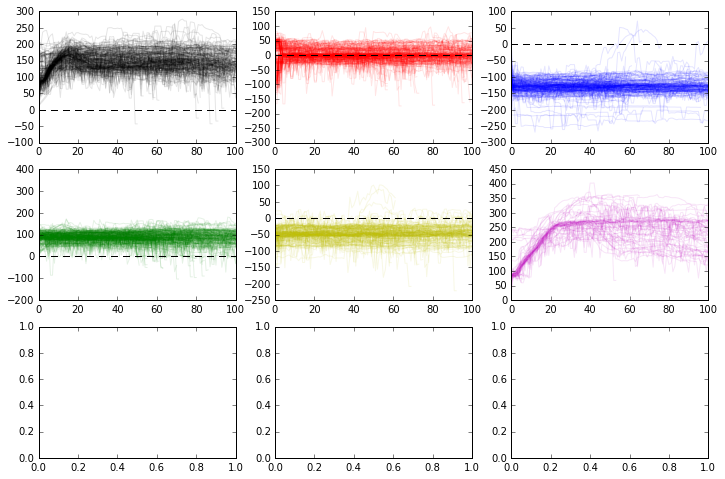

In [97]:
X = [t[:50] for t in all_seg_2_4_month if len(t)>50]

n_clusters=6
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=[12,8]);
ax = ax.flatten()
for i_cluster in range(n_clusters):
    for seg in [x for i,x in enumerate([t for t in all_seg_2_4_month if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')

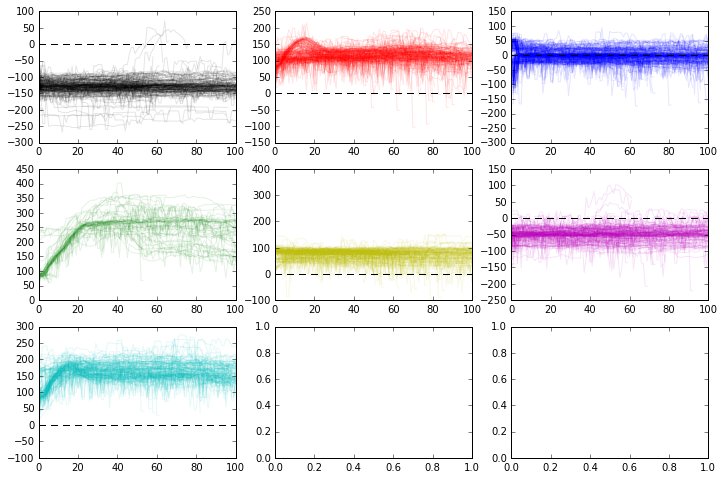

In [98]:
X = [t[:50] for t in all_seg_2_4_month if len(t)>50]

n_clusters=7
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=[12,8]);
ax = ax.flatten()
for i_cluster in range(n_clusters):
    for seg in [x for i,x in enumerate([t for t in all_seg_2_4_month if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')

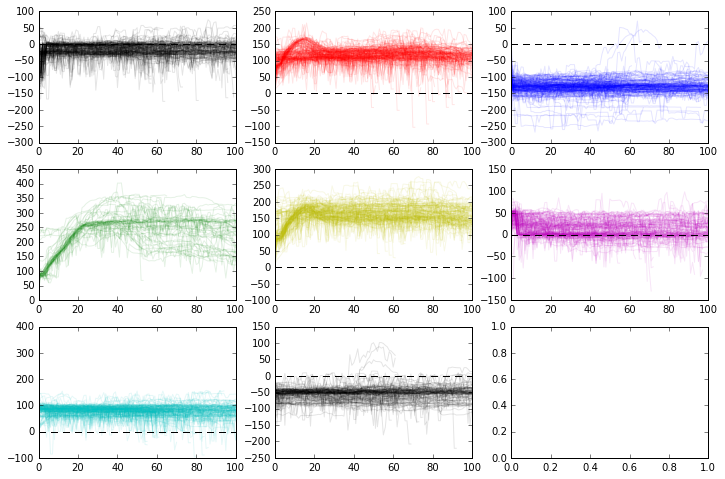

In [99]:
X = [t[:50] for t in all_seg_2_4_month if len(t)>50]

n_clusters=8
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c', 'k', 'r']

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=[12,8]);
ax = ax.flatten()
for i_cluster in range(n_clusters):
    for seg in [x for i,x in enumerate([t for t in all_seg_2_4_month if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')

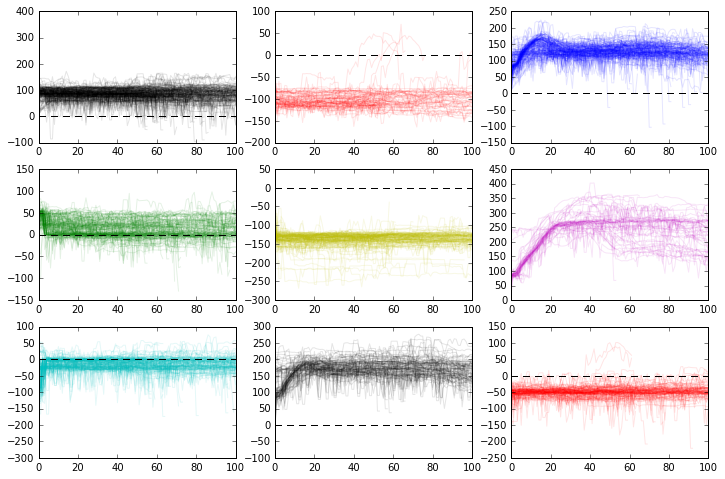

In [100]:
X = [t[:50] for t in all_seg_2_4_month if len(t)>50]

n_clusters=9
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c', 'k', 'r']

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=[12,8]);
ax = ax.flatten()
for i_cluster in range(n_clusters):
    for seg in [x for i,x in enumerate([t for t in all_seg_2_4_month if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')

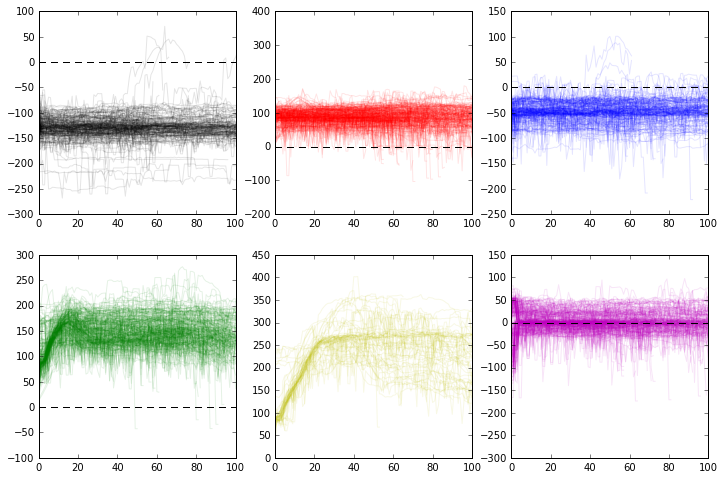

In [101]:
X = [t[:50] for t in all_seg_2_4_month if len(t)>50]

n_clusters=6
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[12,8]);
ax = ax.flatten()
all_seg_2_april_cluster = []

for i_cluster in range(n_clusters):
    all_seg_2_april_cluster.append([x for i,x in enumerate(X) if y_pred[i] == i_cluster])
    for seg in [x for i,x in enumerate([t for t in all_seg_2_4_month if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')
        
power_mean = []
power_std = []
power_diff_mean = []
power_diff_std = []
for i_cluster in range(n_clusters):
    tmp = np.array( [[0]+t for t in all_seg_2_april_cluster[i_cluster]] )
    power_diff_mean.append(np.mean(np.diff(tmp), axis=0))
    power_diff_std.append(np.std(np.diff(tmp), axis=0))
    power_mean.append(np.mean(tmp, axis=0))
    power_std.append(np.std(tmp, axis=0))

(0, 100)

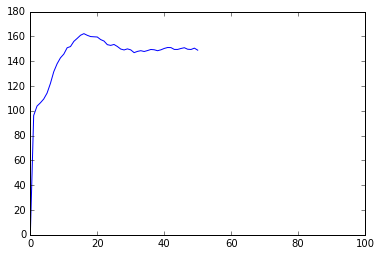

In [136]:
tmp = np.array( [[0]+t for t in all_seg_2_april_cluster[3]] )
x = np.mean(tmp, axis=0)
plt.plot(x)
plt.xlim([0,100])

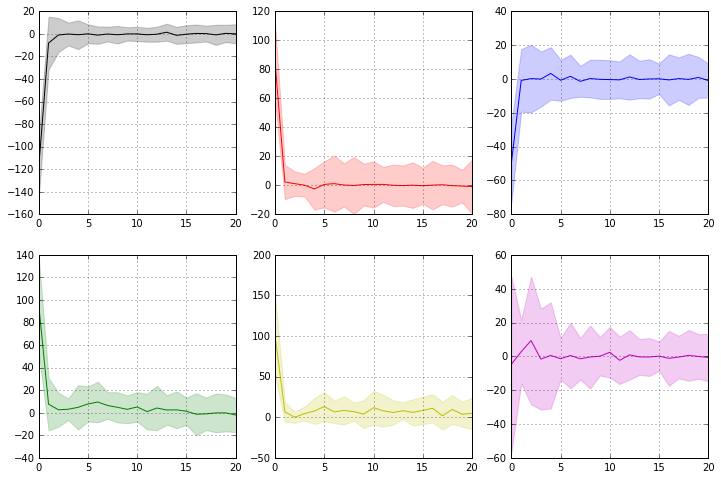

In [204]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[12,8]);
ax = ax.flatten()
color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

for i in range(6):
    ax[i].plot(power_diff_mean[i], color=color_list[i])
    
    ax[i].fill_between(range(len(power_diff_mean[i]))
                     , np.subtract(power_diff_mean[i], power_diff_std[i])
                     , np.add(power_diff_mean[i], power_diff_std[i])
                     , color=color_list[i], alpha=.2)
    ax[i].set_xlim([0,20])
    ax[i].grid()

# for i in range(6):
#     plt.plot(power_diff_mean[i], '-')

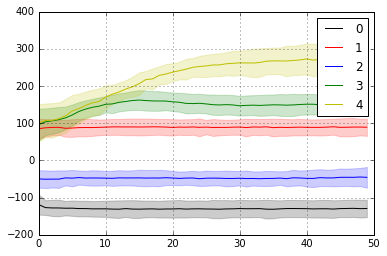

In [227]:
power_mean_mod = [t[1:] for t in power_mean]
power_std_mod = [t[1:] for t in power_std]

power_mean_mod.pop(5)
power_std_mod.pop(5)
color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

for i in range(5):
    plt.plot(power_mean_mod[i], color=color_list[i],label=i)
    plt.fill_between(range(len(power_mean_mod[i]))
                     , np.subtract(power_mean_mod[i], power_std_mod[i])
                     , np.add(power_mean_mod[i], power_std_mod[i])
                     , color=color_list[i], alpha=.2)
plt.grid()
plt.legend()

size of input: 1137
CPU times: user 624 ms, sys: 4.11 ms, total: 628 ms
Wall time: 628 ms


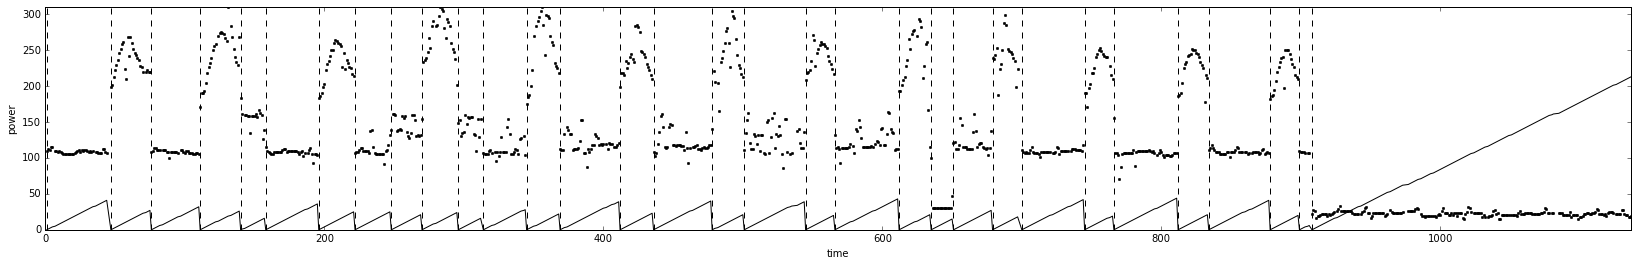

In [104]:
%%time

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23

t, y = rel_change_filter(t, y, thre=.2)
data_input = y

mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = bayesian_change_point_4(data_input, r_blur=30)
changepoint, changepoint_p = get_change_point(prob_r_list_list)
plot_change_point(t, preprocess(data_input), changepoint)
print 'size of input: %d' % len(data_input)


In [779]:
# # zip(t, y)

# t = t_raw_4_16_19_23
# y = y_raw_4_16_19_23

# t, y = rel_change_filter(t, y, thre=.2)

# input_time = t
# input_y = y

# n_shape = len(power_mean_mod)

# r_list = np.array([[20] for i in range(len(power_mean_mod))])
# prob_list = np.array([[np.log(1. / len(power_mean_mod))] for i in range(len(power_mean_mod))]) # in log scale
# last_p = np.array([[input_y[0]] for i in range(len(power_mean_mod))])
# last_datum = input_y[0]

# min_length_prior = 5
# gap_prior = 10.
# SIGMA_LOW = 10. # lowest Sigma of average level
# prob_r_truncation = -10.

# STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
# R_MIN = 10 # min of length of 
# log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
# log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)

# poster_list = []

# for counter, (_, datum) in enumerate(zip(input_time, input_y)):
#     if counter > 39 and counter< 70:
#         inspect_flag = True
#     else:
#         inspect_flag = False
# #     inspect_flag = False
# #     inspect_flag = True
    
#     r_list_prior = r_list.copy()
#     prob_prior = prob_list.copy()
    
#     # calculate P_{1:t}^{t+1} from P_{1:t}^t
#     prob_prior_update = np.array([p+log_H_list[r] for r, p in zip(r_list_prior.flatten(), prob_prior.flatten())])
#     prob_prior_update_0 = sp.misc.logsumexp([p+log_H_2_list[r] for r, p in zip(r_list_prior.flatten(), prob_prior.flatten())]) - np.log(n_shape)    
#     prob_prior_update = [[prob_prior_update_0]+list(t) for t in prob_prior_update.reshape([n_shape, -1])]    

#     r_list = [[0]+list(np.add(t, 1)) for t in r_list]
#     last_p = [[last_datum]+list(t) for t in last_p]

#     if inspect_flag:
#         print 'input data:', counter, datum
#         print 'last_datum', last_datum
#         print 'updated prior prob of tao:', np.array(prob_prior_update)[:,:20]
#         print 'last_p:', np.array(last_p)[:,:20]
#         print 'r_list:', np.array(r_list)[:,:20]

#     pred_prob = []
#     for i_shape in range(n_shape):
#         pred_prob_tmp = []
#         for i_r in range(len(r_list[0])):
#             if r_list[i_shape][i_r] < 50:
#                 t_mean = power_mean_mod[i_shape][r_list[i_shape][i_r]]
#                 t_std = power_std_mod[i_shape][r_list[i_shape][i_r]]
#             else:
#                 t_mean = power_mean_mod[i_shape][-1]
#                 t_std = power_std_mod[i_shape][-1]
#             t_std = 20
#             base_line_before_change = last_p[i_shape][i_r]
            
#             if (counter >=40 and counter <= 43) and i_r < 5 and inspect_flag:
#                 print i_shape, i_r, datum, base_line_before_change, t_mean, t_std
#             pred_prob_tmp.append(-.5 * ((datum-base_line_before_change-t_mean)/t_std)**2
#             - np.log( 1/( np.sqrt(2*np.pi)*t_std ) ))
#         pred_prob.append(pred_prob_tmp)
    
#     t = [p3+p4 for p1, p2 in zip(pred_prob, prob_prior_update) for p3, p4 in zip(p1, p2)]
#     t2 = sp.misc.logsumexp(t)
#     t = [x-t2 for x in t]
#     prob_list = np.array(t).reshape([n_shape, -1])
#     r_list = np.array(r_list)
    
# #     if np.max(prob_list)>.1:
# #         c = np.argmax(prob_list)+1
# #         r = np.ceil(c/t.shape[1])
# #         c = c - (r-1)*t.shape[1]
# #         c = c-1
# #         r = r-1
        
# #         prob_list = [[0]]*5
# #         prob_list[r] = 1
        
# #         r_list = r_list[c]
# #         print 'find best' counter, r_list[c]
#     print counter, np.exp(np.max(prob_list))
    
#     tmp = []
#     for i_shape in range(n_shape):
#         if len(prob_list[i_shape])>10:
#             tmp.append(prob_list[i_shape][10])
#         else:
#             tmp.append(np.nan)
#     poster_list.append(tmp)
    
#     if inspect_flag:
#         print 'prediction prob:', np.array(pred_prob)[:,:20]
#         print 'post_prob', np.array(prob_list)[:,:20]
#         print '================='
#     last_datum = datum

#     if counter>100:
#         break

In [195]:
t = np.array([ [1,2,3,4,3], [3,4,5,14,7], [1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1] ]).T

c = np.argmax(t)+1
r = np.ceil(c/t.shape[1])
c = c - (r-1)*t.shape[1]
print c-1,r-1

1.0 3.0


In [185]:
prob_list.shape, np.array([ [1,2,3,4,3], [3,4,5,14,7], [1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1] ]).T.shape

((5, 403), (5, 6))

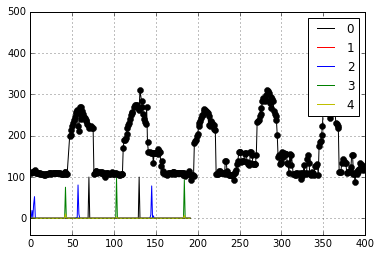

In [223]:
# power_mean_mod
# power_std_mod
plt.plot(input_time, input_y, 'ko-')
plt.grid()

for i in range(5):
    plt.plot([t-10 for t in range(len(poster_list))], [100*np.exp(t[i]) for t in poster_list], color=color_list[i], label=str(i))
plt.xlim([0, 400])
plt.ylim([-40, 500])
plt.legend()

In [219]:
np.diff(range(200), n=5)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

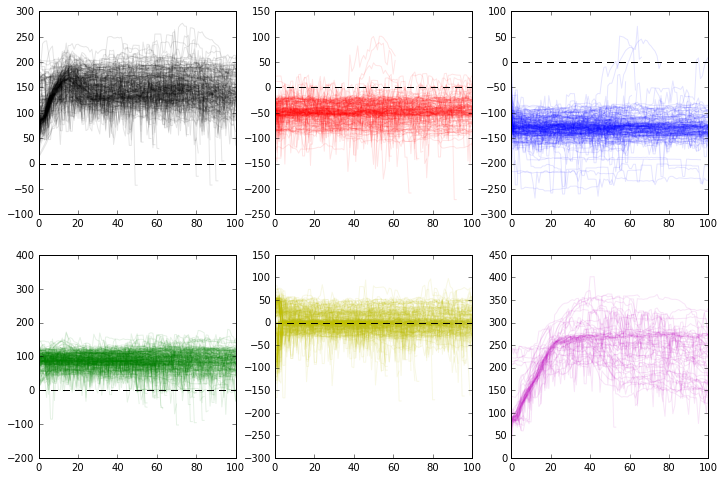

In [256]:
X = [t[:50] for t in all_seg_2_4_month if len(t)>50]

n_clusters=6
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[12,8]);
ax = ax.flatten()
all_seg_2_april_cluster = []

for i_cluster in range(n_clusters):
    all_seg_2_april_cluster.append([x for i,x in enumerate(X) if y_pred[i] == i_cluster])
    for seg in [x for i,x in enumerate([t for t in all_seg_2_4_month if len(t)>50]) if y_pred[i] == i_cluster]:
        ax[i_cluster].plot(seg, '-', linewidth=1, alpha=.1, color=color_list[i_cluster])
        ax[i_cluster].set_xlim([0, 100])
        ax[i_cluster].plot([0,100], [0,0], 'k--')

In [257]:
all_seg_2_april_cluster[5].extend(all_seg_2_april_cluster[0])
# all_seg_2_april_cluster[3]

In [258]:
power_mean = []
power_std = []
power_diff_mean = []
power_diff_std = []
for i_cluster in range(n_clusters):
    tmp = np.array( [[0]+t for t in all_seg_2_april_cluster[i_cluster]] )
    power_diff_mean.append(np.mean(np.diff(tmp), axis=0))
    power_diff_std.append(np.std(np.diff(tmp), axis=0))
    power_mean.append(np.mean(tmp, axis=0))
    power_std.append(np.std(tmp, axis=0))

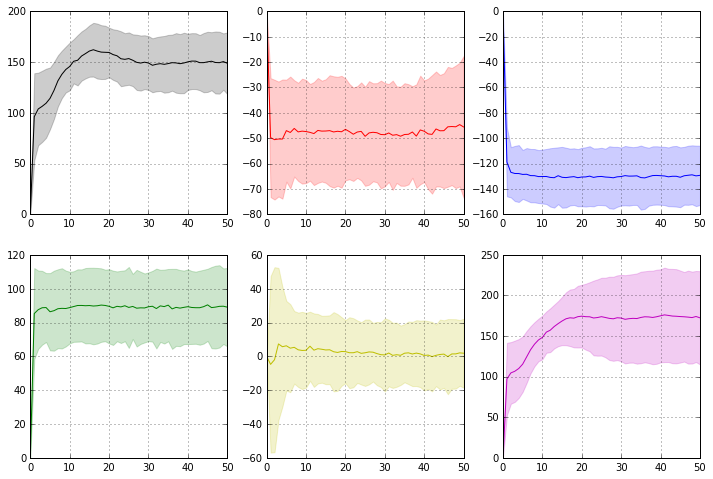

In [259]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[12,8]);
ax = ax.flatten()
color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

for i in range(6):
    ax[i].plot(power_mean[i], color=color_list[i])
    
    ax[i].fill_between(range(len(power_mean[i]))
                     , np.subtract(power_mean[i], power_std[i])
                     , np.add(power_mean[i], power_std[i])
                     , color=color_list[i], alpha=.2)
    ax[i].set_xlim([0,50])
    ax[i].grid()

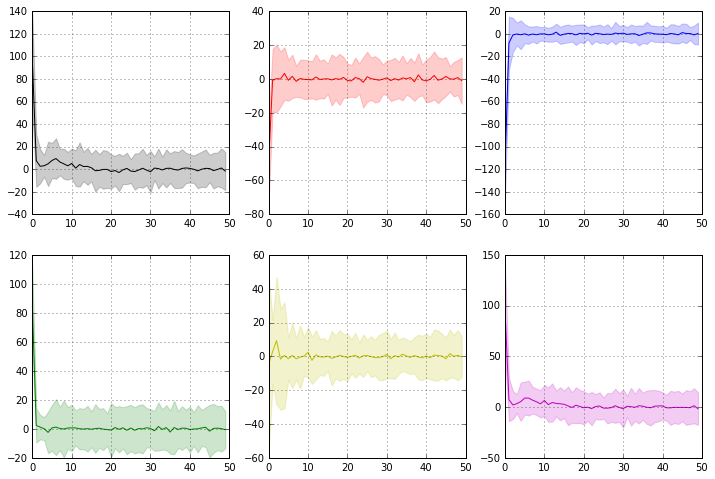

In [264]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[12,8]);
ax = ax.flatten()
color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

for i in range(6):
    ax[i].plot(power_diff_mean[i], color=color_list[i])
    
    ax[i].fill_between(range(len(power_diff_mean[i]))
                     , np.subtract(power_diff_mean[i], power_diff_std[i])
                     , np.add(power_diff_mean[i], power_diff_std[i])
                     , color=color_list[i], alpha=.2)
    ax[i].set_xlim([0,50])
    ax[i].grid()

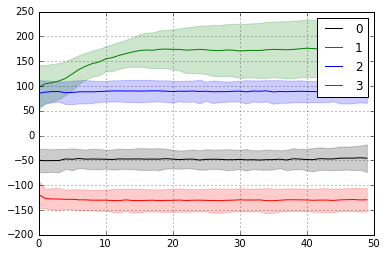

In [262]:
power_mean_mod = [t[1:] for t in power_mean]
power_std_mod = [t[1:] for t in power_std]

power_mean_mod.pop(4)
power_std_mod.pop(4)
power_mean_mod.pop(0)
power_std_mod.pop(0)


color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

for i in range(4):
    plt.plot(power_mean_mod[i], color=color_list[i],label=i)
    plt.fill_between(range(len(power_mean_mod[i]))
                     , np.subtract(power_mean_mod[i], power_std_mod[i])
                     , np.add(power_mean_mod[i], power_std_mod[i])
                     , color=color_list[i], alpha=.2)
plt.grid()
plt.legend()

In [778]:
# # zip(t, y)

# t = t_raw_4_16_19_23
# y = y_raw_4_16_19_23

# t, y = rel_change_filter(t, y, thre=.2)

# input_time = t
# input_y = y

# n_shape = len(power_mean_mod)

# r_list = np.array([[20] for i in range(len(power_mean_mod))])
# prob_list = np.array([[np.log(1. / len(power_mean_mod))] for i in range(len(power_mean_mod))]) # in log scale
# last_p = np.array([[input_y[0]] for i in range(len(power_mean_mod))])
# last_datum = input_y[0]

# min_length_prior = 5
# gap_prior = 10.
# SIGMA_LOW = 10. # lowest Sigma of average level
# prob_r_truncation = -10.

# STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
# R_MIN = 10 # min of length of 
# log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
# log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)

# poster_list = []

# for counter, (_, datum) in enumerate(zip(input_time, input_y)):
#     if counter > 39 and counter< 70:
#         inspect_flag = True
#     else:
#         inspect_flag = False
# #     inspect_flag = False
# #     inspect_flag = True
    
#     r_list_prior = r_list.copy()
#     prob_prior = prob_list.copy()
    
#     # calculate P_{1:t}^{t+1} from P_{1:t}^t
#     prob_prior_update = np.array([p+log_H_list[r] for r, p in zip(r_list_prior.flatten(), prob_prior.flatten())])
#     prob_prior_update_0 = sp.misc.logsumexp([p+log_H_2_list[r] for r, p in zip(r_list_prior.flatten(), prob_prior.flatten())]) - np.log(n_shape)    
#     prob_prior_update = [[prob_prior_update_0]+list(t) for t in prob_prior_update.reshape([n_shape, -1])]    

#     r_list = [[0]+list(np.add(t, 1)) for t in r_list]
#     last_p = [[last_datum]+list(t) for t in last_p]

#     if inspect_flag:
#         print 'input data:', counter, datum
#         print 'last_datum', last_datum
#         print 'updated prior prob of tao:', np.array(prob_prior_update)[:,:20]
#         print 'last_p:', np.array(last_p)[:,:20]
#         print 'r_list:', np.array(r_list)[:,:20]

#     pred_prob = []
#     for i_shape in range(n_shape):
#         pred_prob_tmp = []
#         for i_r in range(len(r_list[0])):
#             if r_list[i_shape][i_r] < 50:
#                 t_mean = power_mean_mod[i_shape][r_list[i_shape][i_r]]
#                 t_std = power_std_mod[i_shape][r_list[i_shape][i_r]]
#             else:
#                 t_mean = power_mean_mod[i_shape][-1]
#                 t_std = power_std_mod[i_shape][-1]
#             t_std = 20
#             base_line_before_change = last_p[i_shape][i_r]
            
#             if (counter >=40 and counter <= 43) and i_r < 5 and inspect_flag:
#                 print i_shape, i_r, datum, base_line_before_change, t_mean, t_std
#             pred_prob_tmp.append(-.5 * ((datum-base_line_before_change-t_mean)/t_std)**2
#             - np.log( 1/( np.sqrt(2*np.pi)*t_std ) ))
#         pred_prob.append(pred_prob_tmp)
    
#     t = [p3+p4 for p1, p2 in zip(pred_prob, prob_prior_update) for p3, p4 in zip(p1, p2)]
#     t2 = sp.misc.logsumexp(t)
#     t = [x-t2 for x in t]
#     prob_list = np.array(t).reshape([n_shape, -1])
#     r_list = np.array(r_list)
    
# #     if np.max(prob_list)>.1:
# #         c = np.argmax(prob_list)+1
# #         r = np.ceil(c/t.shape[1])
# #         c = c - (r-1)*t.shape[1]
# #         c = c-1
# #         r = r-1
        
# #         prob_list = [[0]]*5
# #         prob_list[r] = 1
        
# #         r_list = r_list[c]
# #         print 'find best' counter, r_list[c]
#     print counter, np.exp(np.max(prob_list))
    
#     tmp = []
#     for i_shape in range(n_shape):
#         if len(prob_list[i_shape])>10:
#             tmp.append(prob_list[i_shape][10])
#         else:
#             tmp.append(np.nan)
#     poster_list.append(tmp)
    
#     if inspect_flag:
#         print 'prediction prob:', np.array(pred_prob)[:,:20]
#         print 'post_prob', np.array(prob_list)[:,:20]
#         print '================='
#     last_datum = datum

#     if counter>100:
#         break

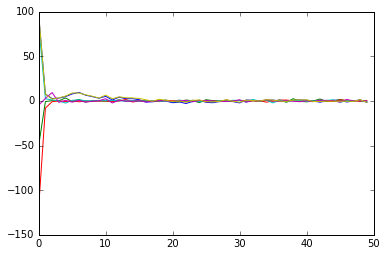

In [270]:
plt.plot(np.array(power_diff_mean).T)

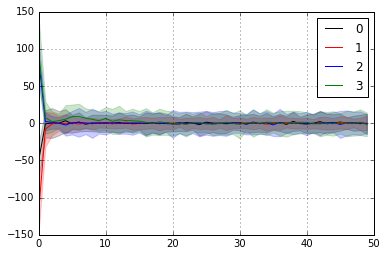

In [272]:
power_diff_mean_mod = [t for t in power_diff_mean]
power_diff_std_mod = [t for t in power_diff_std]

power_diff_mean_mod.pop(4)
power_diff_std_mod.pop(4)
power_diff_mean_mod.pop(0)
power_diff_std_mod.pop(0)

color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']

for i in range(4):
    plt.plot(power_diff_mean_mod[i], color=color_list[i],label=i)
    plt.fill_between(range(len(power_diff_mean_mod[i]))
                     , np.subtract(power_diff_mean_mod[i], power_diff_std_mod[i])
                     , np.add(power_diff_mean_mod[i], power_diff_std_mod[i])
                     , color=color_list[i], alpha=.2)
plt.grid()
plt.legend()

In [777]:
# # zip(t, y)

# t = t_raw_4_16_19_23
# y = y_raw_4_16_19_23

# t, y = rel_change_filter(t, y, thre=.2)

# input_time = t
# input_y = y

# n_shape = len(power_diff_mean_mod)

# r_list = np.array([[20] for i in range(len(power_mean_mod))])
# prob_list = np.array([[np.log(1. / len(power_mean_mod))] for i in range(len(power_mean_mod))]) # in log scale
# last_p = np.array([[input_y[0]] for i in range(len(power_mean_mod))])
# last_datum = input_y[0]

# min_length_prior = 5
# gap_prior = 10.
# SIGMA_LOW = 10. # lowest Sigma of average level
# prob_r_truncation = -10.

# STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
# R_MIN = 10 # min of length of 
# log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
# log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)

# poster_list = []

# for counter, (_, datum) in enumerate(zip(input_time, input_y)):
#     if counter > 39 and counter< 90:
#         inspect_flag = True
#     else:
#         inspect_flag = False
# #     inspect_flag = False
# #     inspect_flag = True
    
#     r_list_prior = r_list.copy()
#     prob_prior = prob_list.copy()
    
#     # calculate P_{1:t}^{t+1} from P_{1:t}^t
#     prob_prior_update = np.array([p+log_H_list[r] for r, p in zip(r_list_prior.flatten(), prob_prior.flatten())])
#     prob_prior_update_0 = sp.misc.logsumexp([p+log_H_2_list[r] for r, p in zip(r_list_prior.flatten(), prob_prior.flatten())]) - np.log(n_shape)    
#     prob_prior_update = [[prob_prior_update_0]+list(t) for t in prob_prior_update.reshape([n_shape, -1])]    

#     r_list = [[0]+list(np.add(t, 1)) for t in r_list]
#     last_p = [[last_datum]+list(t) for t in last_p]
#     if inspect_flag:
#         print 'input data:', counter, datum
#         print 'last_datum', last_datum
#         print 'updated prior prob of tao:', np.array(prob_prior_update)[:,:20]
#         print 'last_p:', np.array(last_p)[:,:20]
#         print 'r_list:', np.array(r_list)[:,:20]

#     pred_prob = []
#     for i_shape in range(n_shape):
#         pred_prob_tmp = []
#         for i_r in range(len(r_list[0])):
#             if r_list[i_shape][i_r] < 50:
#                 t_mean = power_diff_mean_mod[i_shape][r_list[i_shape][i_r]]
#                 t_std = power_diff_std_mod[i_shape][r_list[i_shape][i_r]]
#             else:
#                 t_mean = power_diff_mean_mod[i_shape][-1]
#                 t_std = power_diff_std_mod[i_shape][-1]
#             t_std = 20
#             base_line_before_change = last_p[i_shape][i_r]
            
#             if (counter >=40 and counter <= 43) and i_r < 5 and inspect_flag:
#                 print i_shape, i_r, datum, last_datum, t_mean, t_std
#             pred_prob_tmp.append(-.5 * ((datum-last_datum-t_mean)/t_std)**2
#             - np.log( 1/( np.sqrt(2*np.pi)*t_std ) ))
#         pred_prob.append(pred_prob_tmp)
    
#     t = [p3+p4 for p1, p2 in zip(pred_prob, prob_prior_update) for p3, p4 in zip(p1, p2)]
#     t2 = sp.misc.logsumexp(t)
#     t = [x-t2 for x in t]
#     prob_list = np.array(t).reshape([n_shape, -1])
#     r_list = np.array(r_list)
    
#     if np.max(prob_list)>np.log(.5):
#         break
        
# #         c = np.argmax(prob_list)+1
# #         r = np.ceil(c/prob_list.shape[1])
# #         c = c - (r-1)*prob_list.shape[1]
# #         c = c-1
# #         r = r-1
        
# #         prob_list = [[0]]*5
# #         prob_list[int(r)] = [1]
# #         prob_list = np.array(prob_list)
        
# #         r_list = r_list[c]
# #         print 'find best', counter, r_list[c]
#     print counter, np.exp(np.max(prob_list))
    
#     tmp = []
#     for i_shape in range(n_shape):
#         if len(prob_list[i_shape])>10:
#             tmp.append(prob_list[i_shape][10])
#         else:
#             tmp.append(np.nan)
#     poster_list.append(tmp)
    
#     if inspect_flag:
#         print 'prediction prob:', np.array(pred_prob)[:,:20]
#         print 'post_prob', np.array(prob_list)[:,:20]
#         print '================='
#     last_datum = datum

#     if counter>100:
#         break

In [312]:
counter, r_list, prob_list

(42,
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 63],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 63],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 63],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 63]]),
 array([[-25.30171403, -14.01824361, -13.18387678, -13.79704825,
         -13.4945548 , -13.78201039, -13.15429175, -13.65977398,
         -13.39478738, -13.47017315, -13.677072

In [310]:
c = np.argmax(prob_list)+1
r = np.ceil(c/prob_list.shape[1])
c = c - (r-1)*prob_list.shape[1]
c = c-1
r = r-1
c,r,np.exp(prob_list)

(1.0, 3.0, array([[  1.25559994e-03,   2.49525954e-01],
        [  6.07080429e-10,   2.49742999e-01],
        [  3.11673304e-06,   2.49613865e-01],
        [  2.07959184e-07,   2.49858257e-01]]))

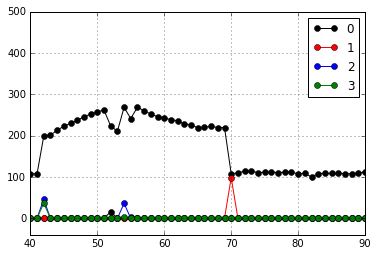

In [303]:
# power_mean_mod
# power_std_mod
plt.plot(input_y, 'ko-')
plt.grid()

for i in range(4):
    plt.plot([t-10 for t in range(len(poster_list))], [100*np.exp(t[i]) for t in poster_list], 'o-', color=color_list[i], label=str(i))
plt.xlim([40, 90])
plt.ylim([-40, 500])
plt.legend()

In [283]:
[(i,j) for i,j in enumerate(poster_list)]

[(0, [nan, nan, nan, nan]),
 (1, [nan, nan, nan, nan]),
 (2, [nan, nan, nan, nan]),
 (3, [nan, nan, nan, nan]),
 (4, [nan, nan, nan, nan]),
 (5, [nan, nan, nan, nan]),
 (6, [nan, nan, nan, nan]),
 (7, [nan, nan, nan, nan]),
 (8, [nan, nan, nan, nan]),
 (9,
  [-1.4170605263431542,
   -1.4098411598171823,
   -1.3966247938548015,
   -1.3992052628030294]),
 (10,
  [-6.1770964069332548,
   -20.873579263200128,
   -12.192509414308599,
   -15.441068710021586]),
 (11,
  [-6.7020087981539715,
   -21.849924607774334,
   -11.370623364943217,
   -14.592204428492137]),
 (12,
  [-5.9970465591124391,
   -20.379210544340992,
   -12.533107188400722,
   -15.798529472578334]),
 (13,
  [-6.6250852645187042,
   -21.802194386715026,
   -11.504055158348503,
   -14.62380014750363]),
 (14,
  [-6.3244508282810195,
   -20.974962404625572,
   -12.041923521209007,
   -15.322455736164205]),
 (15,
  [-5.3867847152343309,
   -18.837284384374016,
   -13.632271055789895,
   -17.057290113182887]),
 (16,
  [-6.2190102604

In [314]:
def extract_first_n(data_list, n):
    return [t[:n] for t in data_list if len(t)>=n]

In [315]:
# example
data_list = [ [1,2,3], [4,5,6,7,8], [1] ]
print extract_first_n(data_list, 2)

[[1, 2], [4, 5]]


In [355]:
all_seg_2_april_truncate_50 = extract_first_n( all_seg_2_april, 50)

In [356]:
# try different number of clusters
def k_mean_cluster(dat, n_cluster):
    return KMeans(n_clusters=n_cluster).fit_predict(dat)

In [357]:
y_pred = k_mean_cluster( all_seg_2_april_truncate_50, 6 )
print y_pred

[5 5 3 0 1 2 1 2 1 5 4 5 5 3 2 0 1 4 1 2 5 1 2 3 2 1 0 4 4 2 2 2 2 2 2 2 0
 0 5 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 5 5 0 2 5 5 5 3 1 2 0 3 0 1 2 0 1 4 1 2
 0 0 5 5 0 3 2 1 2 1 0 1 5 4 4 4 4 0 4 2 4 0 0 0 0 0 0 5 3 0 1 2 1 2 1 2 4
 5 0 0 0 0 3 2 5 5 0 3 2 1 2 1 2 1 4 3 2 1 2 1 2 1 4 1 1 2 1 2 1 4 1 2 1 2
 5 3 2 1 2 1 0 1 5 1 0 1 2 1 2 1 4 3 2 1 4 1 2 1 4 1 0 1 4 1 4 1 4 0 4 4 3
 2 4 2 4 0 0 5 3 2 2 3 2 4 4 5 3 2 1 5 1 2 1 0 1 2 1 2 1 2 1 4 5 0 3 0 4 4
 5 5 0 0 5 5 3 4 4 4 5 0 0 5 3 2 3 2 4 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 3 2
 1 5 1 5 1 4 1 4 1 5 0 1 1 2 1 2 2 2 2 3 2 1 4 1 2 5 5 5 3 2 1 0 1 2 1 1 2
 1 2 1]


In [396]:
def plot_cluster(dat, y_pred):
    color_list = ['k', 'r', 'b', 'g', 'y', 'm', 'c']
    nrows = int(np.ceil(max(y_pred)/3))
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=[12, 4*nrows])
    ax = ax.flatten()
    
    cluster_mean = []
    cluster_std = []
    
    for i_cluster in range(max(y_pred)):
        dat_tmp = []
        for seg in np.array( [dat[i] for i in range(len(y_pred)) if y_pred[i] == i_cluster]):
            ax[i_cluster].plot(seg, color=color_list[i_cluster], alpha=.2)
            dat_tmp.append(seg)
        ax[i_cluster].plot([0,50], [0,0], 'k--', linewidth=1)
        ax[i_cluster].set_ylim([-200, 400])
        dat_mean=np.mean(dat_tmp, axis=0)
        dat_std=np.std(dat_tmp, axis=0)
        ax[i_cluster].plot(dat_mean, color=color_list[i_cluster])
        ax[i_cluster].plot(np.add(dat_mean, dat_std), '--', color=color_list[i_cluster], linewidth=1)
        ax[i_cluster].plot(np.subtract(dat_mean, dat_std), '--', color=color_list[i_cluster], linewidth=1)
        
        cluster_mean.append(dat_mean)
        cluster_std.append(dat_std)
    
    return cluster_mean, cluster_std

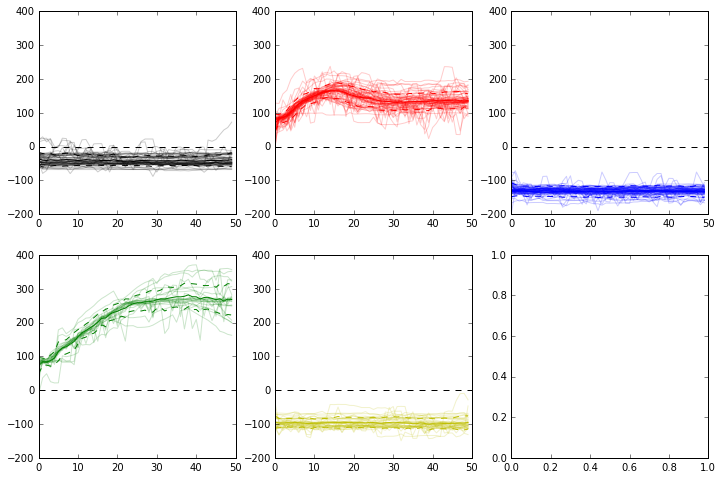

In [397]:
cluster_mean, cluster_std = plot_cluster(all_seg_2_april_truncate_50, y_pred)

In [712]:
def evolve_prob(prior_prob, r_list, retain_prob):
    new_prob = []
    for t in prior_prob:
        new_prob.append([retain_prob[r]+p for p, r in zip(t, r_list)])
    return new_prob

print evolve_prob([[-1, -2],[-3, -4]], [2,4], [1,2,3,4,5])

def sum_prob(prob):
    return sp.misc.logsumexp(prob)
print sum_prob([[1,2], [3,4]]), sum_prob([1,2,3,4])
print sum_prob([1,2]), np.log(np.sum(np.exp(1)+np.exp(2)))

def add_to_all(list_of_list, val):
    res = []
    for l in list_of_list:
        res.append([x+val for x in l])
    return res
print add_to_all([[1,2],[3,4,5]],2)

def add_to_front(new_front, list_of_list):
    return [[new_front]+t for t in list_of_list]
print add_to_front(1, [[2],[3,4],[]])

# np.argmax(prior_list), prior_list, r_list
a = [[1,2,33],[4,5,12]]
np.argmax(a)
def get_max_id(list_of_list):
    n_list = len(list_of_list)
    list_size = len(list_of_list[0])
    t = np.argmax(list_of_list)+1
    i_list = np.ceil(t / list_size) - 1
    pos_in_list = t - i_list * list_size - 1
    return int(i_list), int(pos_in_list)
get_max_id(a)

def select_from_list(list_of_list, id):
    result = []
    for l in list_of_list:
        result.append([l[i] for i in id])
    return result
print select_from_list([[1,2,3], [3,4,5], [2,3,4,6]], [0,2])

def create_counter(mem=100):
    return {'mem':mem, 'dat':[0 for i in range(mem)],'start':0}

def vote(obj, counter, pos, p):
    while obj['start'] < counter - obj['mem'] + 1:
        obj['dat'].pop(0)
        obj['dat'].append(0)
        obj['start'] += 1
    if pos-obj['start']>=0:
        obj['dat'][pos-obj['start']]+=p
    return obj
    
def search_call(obj, thre):
    return [pos+obj['start'] for pos, p in enumerate(obj['dat']) if p > thre]

# a = create_counter()
# print a
# a = vote(a, 1, 1, 2)
# print search_call(a, 5)
# print a

# a = vote(a, 100, 1, 2)
# print search_call(a, 5)
# print a

# a = vote(a, 100, 1, 2)
# print search_call(a, 5)
# print a

# a = vote(a, 101, 13, 20)
# print search_call(a, 5)
# print a

[[2, 3], [0, 1]]
4.44018969856 4.44018969856
2.31326168752 2.31326168752
[[3, 4], [5, 6, 7]]
[[1, 2], [1, 3, 4], [1]]
[[1, 3], [3, 5], [2, 4]]


In [733]:
def update_prob(datum, prior_prob, r_list, mu_list, sigma_list, shapes, mu_prior, sigma_measurement):
    n_shape = len(shapes) # the number of possible change points
    n_r = len(r_list) # the number of r(s), r is the distance to the last change point
    shape_len = len(shapes[0])
    flag_print = False
    if flag_print:
        print 'shape_len', shape_len
        print 'datum', datum
        print 'mu_prior (last point)', mu_prior
#     if len(r_list) != n_shape:
#         raise('the number of r list does not match to the number of shapes')
    if len(prior_prob) != n_shape:
        raise('the number of prior prob does not match to the number of shapes')
    for t in prior_prob:
        if len(t) != n_r:
            print len(t), n_r
            raise('number of r does not match to probs')
    for t in mu_list:
        if len(t) != n_r:
            raise('number of r does not match to mu')
    for t in sigma_list:
        if len(t) != n_r:
            raise('number of r does not match to sigma')
    
    TOL = .9999
    
    gap_prior = 100.
    min_length_prior = 5
    STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
    log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
    log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)
    
    if flag_print:
        print 'prior_prob', prior_prob
        print 'r_list', r_list
        print 'mu_list', mu_list
        print 'sigma_list', sigma_list

    # step 1, calculate the new probabilty of prior_prob, considering part of 
    # the possibility will go to new change point
    prior_prob_plus_1 = evolve_prob(prior_prob, r_list, log_H_list)
    prob_change = np.log((1-np.exp(sum_prob(prior_prob_plus_1)))/n_shape)
    prob_update = [[prob_change]+t for t in prior_prob_plus_1]
    if flag_print:
        print 'step 1'
        print prob_update, sum_prob(prob_update)
    
    # step 2: update r_list
    r_list_update = [0] + [t+1 for t in r_list]
    if flag_print:
        print 'step 2'
        print 'r_list_update', r_list_update
    
    # step 3: update u and sigma
    mu_prior = mu_prior
    sigma_prior = 50
    mu_list_update = add_to_front(mu_prior, mu_list)
    sigma_list_update = add_to_front(sigma_prior, sigma_list)
    if flag_print:
        print 'step 3'
        print 'mu_list_update', mu_list_update
        print 'sigma_list_update', sigma_list_update
    
    # step 4: predict prob
    mu_list_post = []
    sigma_list_post = []
    prob_list_post = []
    for i_shape in range(n_shape):
        mu_list_post_tmp = []
        sigma_list_post_tmp = []
        prob_list_post_tmp = []
        for i_r in range(n_r+1): # because everything shifted by 1
            r = r_list_update[i_r]
            mu = mu_list_update[i_shape][i_r]
            sigma = sigma_list_update[i_shape][i_r]
            if r < shape_len:
                shape_value = shapes[i_shape][r]
            else:
                shape_value = shapes[i_shape][-1]
            mu_with_shift = mu + shape_value
            # update sigma and mu, note that mu is considered as shift
            mu_update_with_shift = (mu_with_shift*sigma_measurement**2+datum*sigma**2)/(sigma_measurement**2+sigma**2)
            mu_update = mu_update_with_shift-shape_value
            sigma_update = np.sqrt(sigma_measurement**2*sigma**2/(sigma_measurement**2+sigma**2))
            
            prob = prob_update[i_shape][i_r]
            predict_prob = -((datum-mu_with_shift)/sigma_measurement)**2/2.0-np.log(sigma_measurement) 
            prob_post = prob + predict_prob
            
            if flag_print:
                print i_shape, i_r, 'r:', r, 'mu', mu, 'sigma', sigma, 'mu_with_shift', mu_with_shift
                print 'datum', datum, 
                print 'mu_update_with_shift', mu_update_with_shift, 'mu_update', mu_update, 'sigma_update', sigma_update
                print 'prob', prob, 'predict_prob', predict_prob, 'prob_post', prob_post
            mu_list_post_tmp.append(mu_update)
            sigma_list_post_tmp.append(sigma_update)
            prob_list_post_tmp.append(prob_post)
        mu_list_post.append(mu_list_post_tmp)
        sigma_list_post.append(sigma_list_post_tmp)
        prob_list_post.append(prob_list_post_tmp)
    
    # truncation
    t = sum_prob(prob_list_post)
    prob_list_post = add_to_all(prob_list_post, -t)

    # test if truncation is possible
    cum_pro = np.cumsum( np.sum(np.exp(prob_list_post),axis=0) )
    i_r_max = np.min([i for i, pro in enumerate(cum_pro) if pro > TOL]);
    if flag_print:
        print 'current r_max', r_list_update[i_r_max]
    if i_r_max<10:
        if flag_print:
            print 'i_r_max too small, do not truncate'
        i_r_max = len(cum_pro)-1

    if flag_print:
        print 'cum_pro', cum_pro
        print 'mu_list_post', mu_list_post
        print 'sigma_list_post', sigma_list_post
        print 'prob_list_post', prob_list_post, sum_prob(prob_list_post)
        print 'r_list_update', r_list_update

    mu_list_post = extract_first_n(mu_list_post, i_r_max+1)
    sigma_list_post = extract_first_n(sigma_list_post, i_r_max+1)
    prob_list_post = extract_first_n(prob_list_post, i_r_max+1)
    r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
    if flag_print:
        print 'total r(s)', len(cum_pro), 'truncation', i_r_max
        
    # a second round of truncation for flat signals, truncate from the end
    if len(r_list_update) > 30:
        r_max = np.max(r_list_update)
        valid_r = [i for i,t in enumerate(r_list_update) if t < 30 or t >= r_max-30]
        mu_list_post = select_from_list(mu_list_post, valid_r)
        sigma_list_post = select_from_list(sigma_list_post, valid_r)
        prob_list_post = select_from_list(prob_list_post, valid_r)
        r_list_update = [r_list_update[i] for i in valid_r]
#         r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
        
        
    # find the highest p
    i_shape_ml, i_r_ml = get_max_id(prob_list_post)
    if flag_print:
        print 'best prob is shape %d and dist to the last cp is %d' % (i_shape_ml, r_list_update[i_r_ml])
        
    if flag_print:
        print 'mu_list_post', mu_list_post
        print 'sigma_list_post', sigma_list_post
        print 'prob_list_post', prob_list_post, sum_prob(prob_list_post)
        print 'r_list_update', r_list_update
    return prob_list_post, mu_list_post, sigma_list_post, r_list_update, (i_shape_ml, r_list_update[i_r_ml], np.max(prob_list_post))


In [743]:
%%time
sigma_init = 20

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23
t, y = rel_change_filter(t, y, thre=.2)

n_shapes = len(cluster_mean)

r_list = [0]
prior_list = [[np.log(1/n_shapes)]] * n_shapes
mu_list = [[0]] * n_shapes
sigma_list =[[sigma_init]] * n_shapes

# print r_list
# print prior_list
# print mu_list
# print sigma_list

last_y = 100
sigma_measurement = 20
cp_results = []
cp_counter = create_counter()
all_cp = []
r_list_len = []
counter_max = 800
for counter in range(len(y)):
    prior_list, mu_list, sigma_list, r_list, most_likely_cp = update_prob(y[counter], prior_list, r_list, mu_list, sigma_list, cluster_mean, last_y, sigma_measurement)
    vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
    cp = search_call(cp_counter, 1)
    all_cp.extend(cp)
    all_cp = list(set(all_cp))
    cp_results.append(most_likely_cp)
    r_list_len.append(len(r_list))
    
    last_y = y[counter]
    if counter >=counter_max:
        break
all_cp = np.sort(all_cp)

CPU times: user 1.83 s, sys: 29 ms, total: 1.86 s
Wall time: 1.85 s


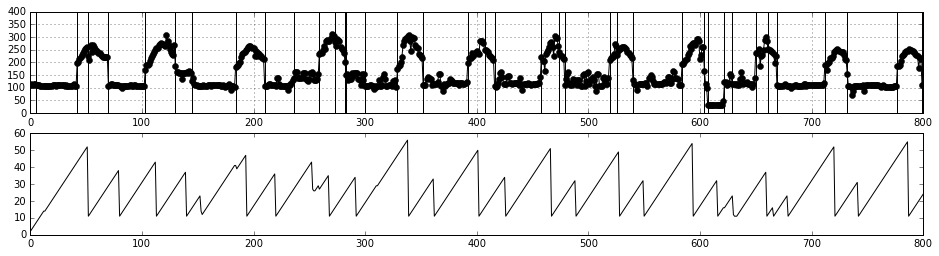

In [744]:
_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

In [775]:
def on_line_disaggregate(t,y,cluster_mean):
    sigma_init = 20

    n_shapes = len(cluster_mean)

    r_list = [0]
    prior_list = [[np.log(1/n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    counter_max = 800
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp = update_prob(y[counter], prior_list, r_list, mu_list, sigma_list, cluster_mean, last_y, sigma_measurement)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 1)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]
        if counter >=counter_max:
            break
    all_cp = np.sort(all_cp)
    return all_cp, r_list_len

In [776]:
%%time

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23
t, y = rel_change_filter(t, y, thre=.2)
all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)


CPU times: user 1.82 s, sys: 16.3 ms, total: 1.83 s
Wall time: 1.85 s


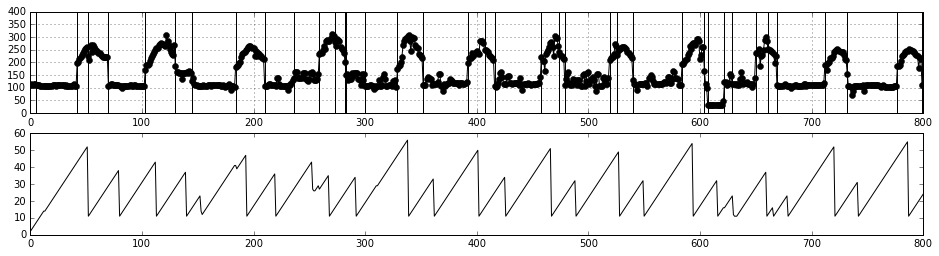

In [753]:
_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

In [754]:
%%time

t = t_raw_4_3_7_18
y = y_raw_4_3_7_18
t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)


CPU times: user 3.41 s, sys: 34.1 ms, total: 3.44 s
Wall time: 3.43 s


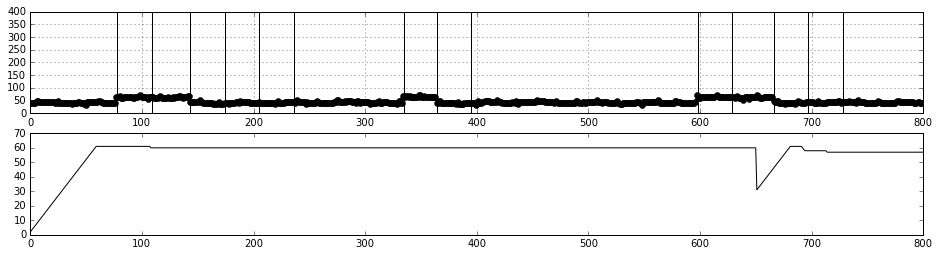

In [755]:
_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

In [756]:
%%time

t = t_raw_4_4_7_18
y = y_raw_4_4_7_18
t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)


CPU times: user 3.77 s, sys: 92.3 ms, total: 3.86 s
Wall time: 3.94 s


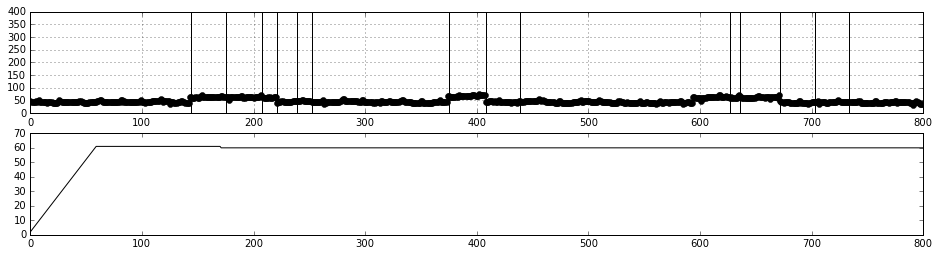

In [757]:
_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-23 7 18


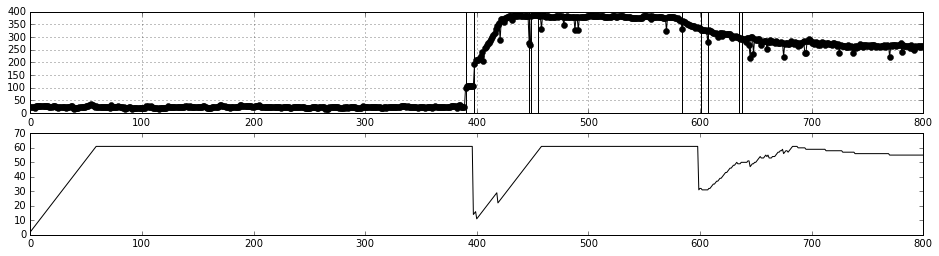

In [765]:
date_current = datetime.datetime(2016,5,23)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-24 7 18


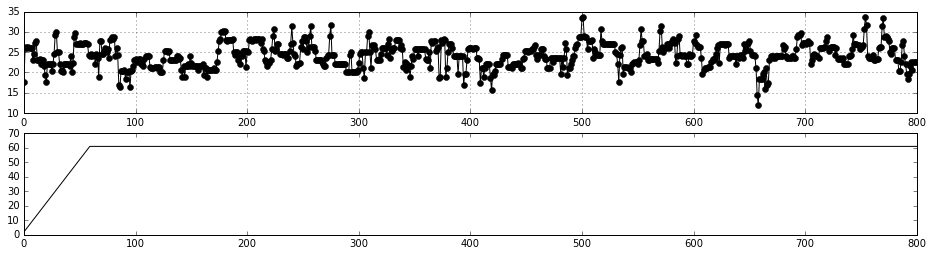

In [766]:
date_current = datetime.datetime(2016,5,24)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-25 7 18


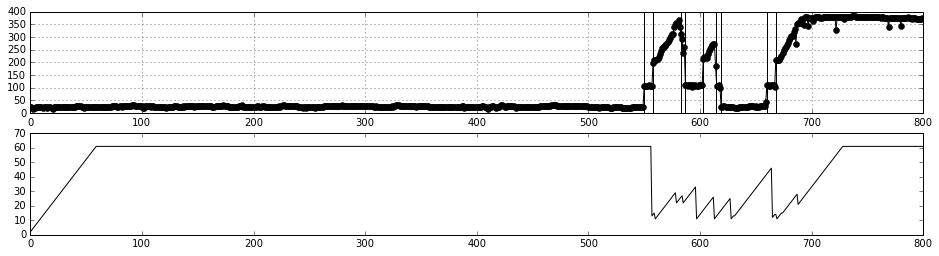

In [767]:
date_current = datetime.datetime(2016,5,25)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-25 7 18


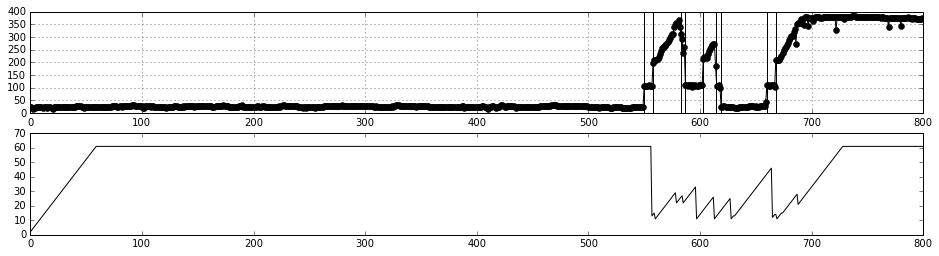

In [768]:
date_current = datetime.datetime(2016,5,25)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-26 7 18


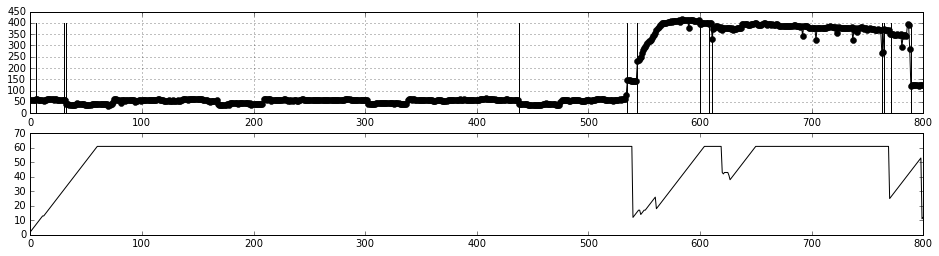

In [769]:
date_current = datetime.datetime(2016,5,26)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-27 7 18


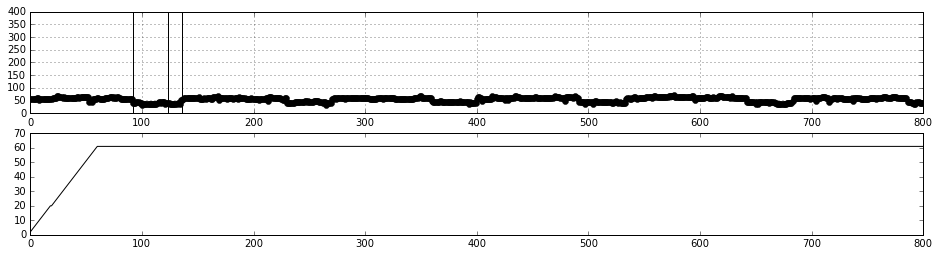

In [770]:
date_current = datetime.datetime(2016,5,27)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-28 7 18


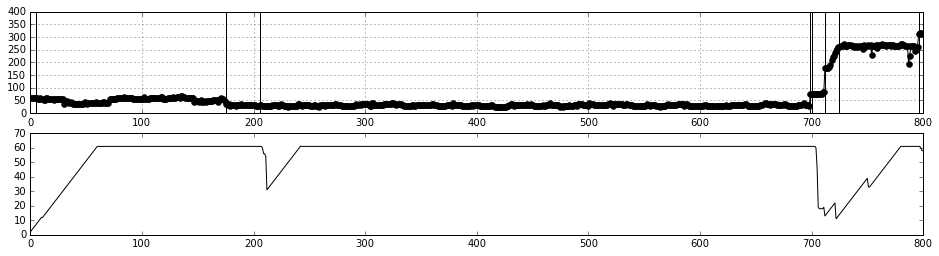

In [771]:
date_current = datetime.datetime(2016,5,28)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-29 7 18


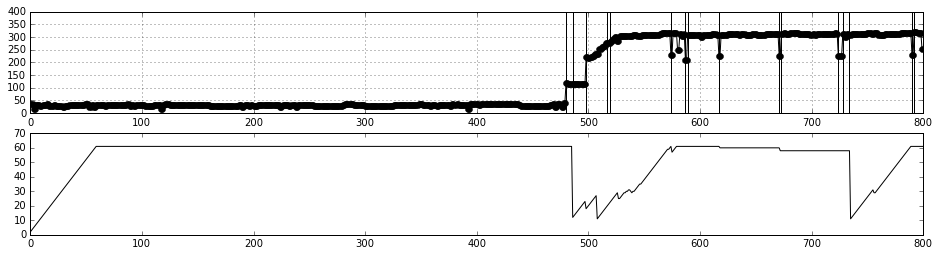

In [772]:
date_current = datetime.datetime(2016,5,29)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

In [788]:
def update_prob_2(datum, prior_prob, r_list, mu_list, sigma_list, shapes, mu_prior, sigma_measurement, shape_std):
    n_shape = len(shapes) # the number of possible change points
    n_r = len(r_list) # the number of r(s), r is the distance to the last change point
    shape_len = len(shapes[0])
    flag_print = False
    if flag_print:
        print 'shape_len', shape_len
        print 'datum', datum
        print 'mu_prior (last point)', mu_prior
#     if len(r_list) != n_shape:
#         raise('the number of r list does not match to the number of shapes')
    if len(prior_prob) != n_shape:
        raise('the number of prior prob does not match to the number of shapes')
    for t in prior_prob:
        if len(t) != n_r:
            print len(t), n_r
            raise('number of r does not match to probs')
    for t in mu_list:
        if len(t) != n_r:
            raise('number of r does not match to mu')
    for t in sigma_list:
        if len(t) != n_r:
            raise('number of r does not match to sigma')
    
    TOL = .9999
    
    gap_prior = 100.
    min_length_prior = 5
    STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
    log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
    log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)
    
    if flag_print:
        print 'prior_prob', prior_prob
        print 'r_list', r_list
        print 'mu_list', mu_list
        print 'sigma_list', sigma_list

    # step 1, calculate the new probabilty of prior_prob, considering part of 
    # the possibility will go to new change point
    prior_prob_plus_1 = evolve_prob(prior_prob, r_list, log_H_list)
    prob_change = np.log((1-np.exp(sum_prob(prior_prob_plus_1)))/n_shape)
    prob_update = [[prob_change]+t for t in prior_prob_plus_1]
    if flag_print:
        print 'step 1'
        print prob_update, sum_prob(prob_update)
    
    # step 2: update r_list
    r_list_update = [0] + [t+1 for t in r_list]
    if flag_print:
        print 'step 2'
        print 'r_list_update', r_list_update
    
    # step 3: update u and sigma
    mu_prior = mu_prior
    sigma_prior = 50
    mu_list_update = add_to_front(mu_prior, mu_list)
    sigma_list_update = add_to_front(sigma_prior, sigma_list)
    if flag_print:
        print 'step 3'
        print 'mu_list_update', mu_list_update
        print 'sigma_list_update', sigma_list_update
    
    # step 4: predict prob
    mu_list_post = []
    sigma_list_post = []
    prob_list_post = []
    for i_shape in range(n_shape):
        mu_list_post_tmp = []
        sigma_list_post_tmp = []
        prob_list_post_tmp = []
        for i_r in range(n_r+1): # because everything shifted by 1
            r = r_list_update[i_r]
            mu = mu_list_update[i_shape][i_r]
            sigma = sigma_list_update[i_shape][i_r]
            if r < shape_len:
                shape_value = shapes[i_shape][r]
                extra_sigma = shape_std[i_shape][r]
            else:
                shape_value = shapes[i_shape][-1]
                extra_sigma = shape_std[i_shape][-1]
            mu_with_shift = mu + shape_value
            # sigma = np.sqrt(sigma**2 + extra_sigma**2)
            # update sigma and mu, note that mu is considered as shift
            sigma_measurement_tmp = np.sqrt(sigma_measurement**2+extra_sigma**2)
            mu_update_with_shift = (mu_with_shift*sigma_measurement_tmp**2+datum*sigma**2)/(sigma_measurement_tmp**2+sigma**2)
            mu_update = mu_update_with_shift-shape_value
            sigma_update = np.sqrt(sigma_measurement_tmp**2*sigma**2/(sigma_measurement_tmp**2+sigma**2))
#             try:
#                 sigma_update = np.sqrt(sigma_update**2-)
            
            prob = prob_update[i_shape][i_r]
            predict_prob = -((datum-mu_with_shift)/sigma_measurement_tmp)**2/2.0-np.log(sigma_measurement_tmp) 
            prob_post = prob + predict_prob
            
            if flag_print:
                print i_shape, i_r, 'r:', r, 'mu', mu, 'sigma', sigma, 'mu_with_shift', mu_with_shift
                print 'datum', datum, 
                print 'mu_update_with_shift', mu_update_with_shift, 'mu_update', mu_update, 'sigma_update', sigma_update
                print 'prob', prob, 'predict_prob', predict_prob, 'prob_post', prob_post
            mu_list_post_tmp.append(mu_update)
            sigma_list_post_tmp.append(sigma_update)
            prob_list_post_tmp.append(prob_post)
        mu_list_post.append(mu_list_post_tmp)
        sigma_list_post.append(sigma_list_post_tmp)
        prob_list_post.append(prob_list_post_tmp)
    
    # truncation
    t = sum_prob(prob_list_post)
    prob_list_post = add_to_all(prob_list_post, -t)

    # test if truncation is possible
    cum_pro = np.cumsum( np.sum(np.exp(prob_list_post),axis=0) )
    i_r_max = np.min([i for i, pro in enumerate(cum_pro) if pro > TOL]);
    if flag_print:
        print 'current r_max', r_list_update[i_r_max]
    if i_r_max<10:
        if flag_print:
            print 'i_r_max too small, do not truncate'
        i_r_max = len(cum_pro)-1

    if flag_print:
        print 'cum_pro', cum_pro
        print 'mu_list_post', mu_list_post
        print 'sigma_list_post', sigma_list_post
        print 'prob_list_post', prob_list_post, sum_prob(prob_list_post)
        print 'r_list_update', r_list_update

    mu_list_post = extract_first_n(mu_list_post, i_r_max+1)
    sigma_list_post = extract_first_n(sigma_list_post, i_r_max+1)
    prob_list_post = extract_first_n(prob_list_post, i_r_max+1)
    r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
    if flag_print:
        print 'total r(s)', len(cum_pro), 'truncation', i_r_max
        
    # a second round of truncation for flat signals, truncate from the end
    if len(r_list_update) > 30:
        r_max = np.max(r_list_update)
        valid_r = [i for i,t in enumerate(r_list_update) if t < 30 or t >= r_max-30]
        mu_list_post = select_from_list(mu_list_post, valid_r)
        sigma_list_post = select_from_list(sigma_list_post, valid_r)
        prob_list_post = select_from_list(prob_list_post, valid_r)
        r_list_update = [r_list_update[i] for i in valid_r]
#         r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
        
        
    # find the highest p
    i_shape_ml, i_r_ml = get_max_id(prob_list_post)
    if flag_print:
        print 'best prob is shape %d and dist to the last cp is %d' % (i_shape_ml, r_list_update[i_r_ml])
        
    if flag_print:
        print 'mu_list_post', mu_list_post
        print 'sigma_list_post', sigma_list_post
        print 'prob_list_post', prob_list_post, sum_prob(prob_list_post)
        print 'r_list_update', r_list_update
    return prob_list_post, mu_list_post, sigma_list_post, r_list_update, (i_shape_ml, r_list_update[i_r_ml], np.max(prob_list_post))


In [789]:
%%time
sigma_init = 20

t = t_raw_4_16_19_23
y = y_raw_4_16_19_23
t, y = rel_change_filter(t, y, thre=.2)

n_shapes = len(cluster_mean)

r_list = [0]
prior_list = [[np.log(1/n_shapes)]] * n_shapes
mu_list = [[0]] * n_shapes
sigma_list =[[sigma_init]] * n_shapes

# print r_list
# print prior_list
# print mu_list
# print sigma_list

last_y = 100
sigma_measurement = 20
cp_results = []
cp_counter = create_counter()
all_cp = []
r_list_len = []
counter_max = 800
for counter in range(len(y)):
    prior_list, mu_list, sigma_list, r_list, most_likely_cp = update_prob_2(y[counter], prior_list, r_list, mu_list, sigma_list, cluster_mean, last_y, sigma_measurement, cluster_std)
    vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
    cp = search_call(cp_counter, 1)
    all_cp.extend(cp)
    all_cp = list(set(all_cp))
    cp_results.append(most_likely_cp)
    r_list_len.append(len(r_list))
    
    last_y = y[counter]
    if counter >=counter_max:
        break
all_cp = np.sort(all_cp)

CPU times: user 1.95 s, sys: 15.7 ms, total: 1.97 s
Wall time: 1.99 s


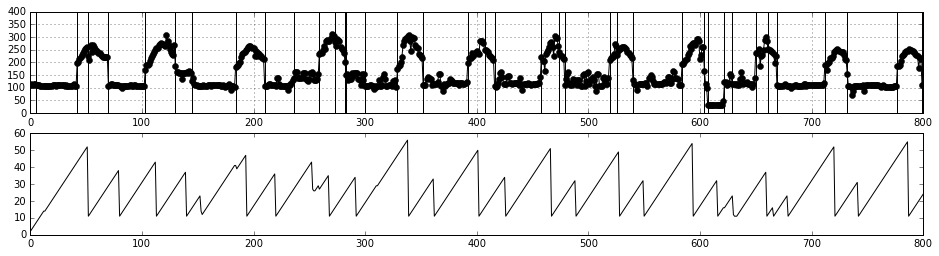

In [782]:
_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

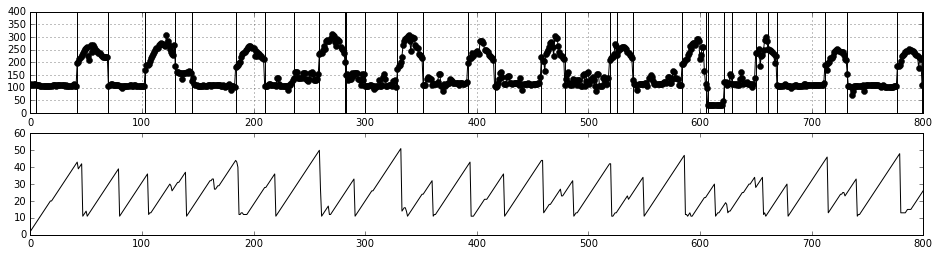

In [790]:
_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

In [791]:
def on_line_disaggregate_2(t,y,cluster_mean):
    sigma_init = 20

    n_shapes = len(cluster_mean)

    r_list = [0]
    prior_list = [[np.log(1/n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    counter_max = 800
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp = update_prob_2(y[counter], prior_list, r_list, mu_list, sigma_list, cluster_mean, last_y, sigma_measurement,cluster_std)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 1)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]
        if counter >=counter_max:
            break
    all_cp = np.sort(all_cp)
    return all_cp, r_list_len

5-23 7 18


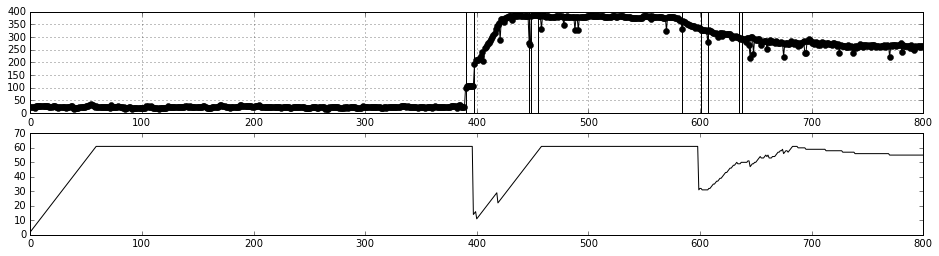

In [793]:
date_current = datetime.datetime(2016,5,23)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')

5-23 7 18


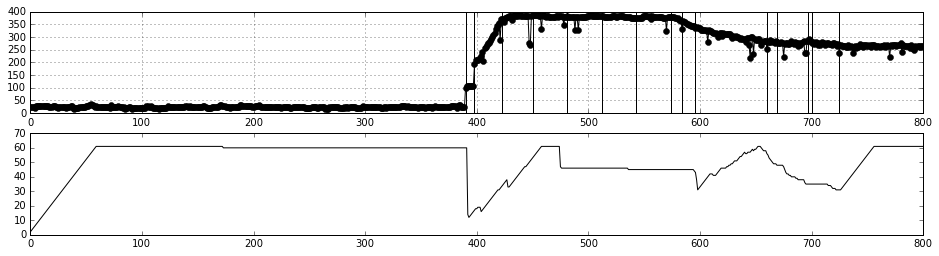

In [794]:
date_current = datetime.datetime(2016,5,23)
date = str(date_current.month) + '-' + str(date_current.day)

Hstart=7
Hend=18

print date, Hstart, Hend

dat = read_dat(date_current, Hstart, Hend, folder_path='new_data/IHG')
y = dat
t = range(len(y)) # fake time

t, y = rel_change_filter(t, y, thre=.2)

all_cp, r_list_len = on_line_disaggregate_2(t,y,cluster_mean)

_, ax = plt.subplots(nrows=2,figsize=[16,4])
ax[0].plot(y[:counter_max], 'ko-')
for cp in all_cp:
    ax[0].plot([cp,cp], [0,400], 'k')
ax[0].grid()

ax[1].plot(r_list_len, 'k-')